X shape: (15696, 50)
y shape: (15696,)


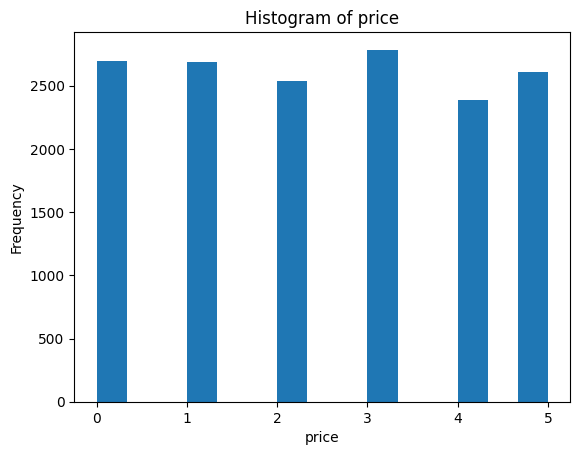

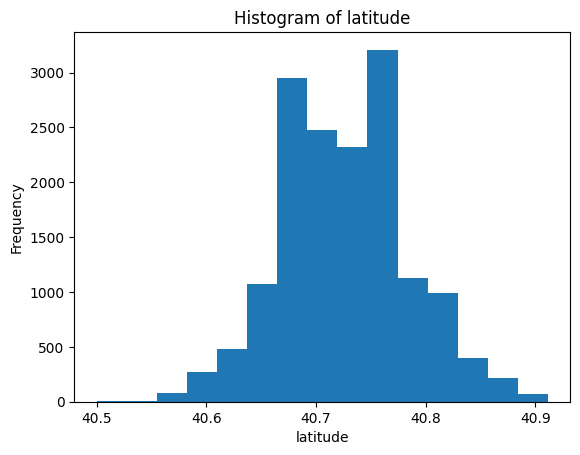

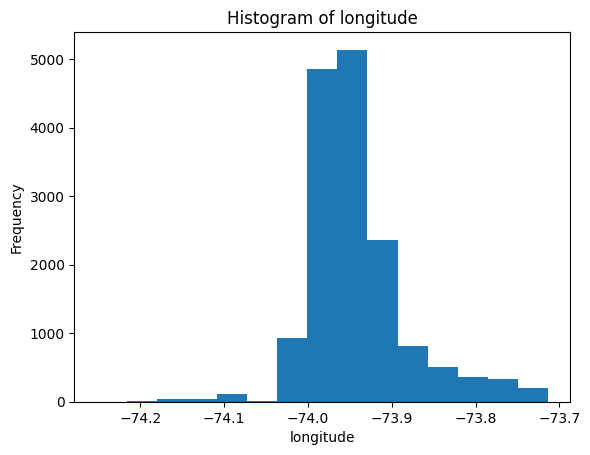

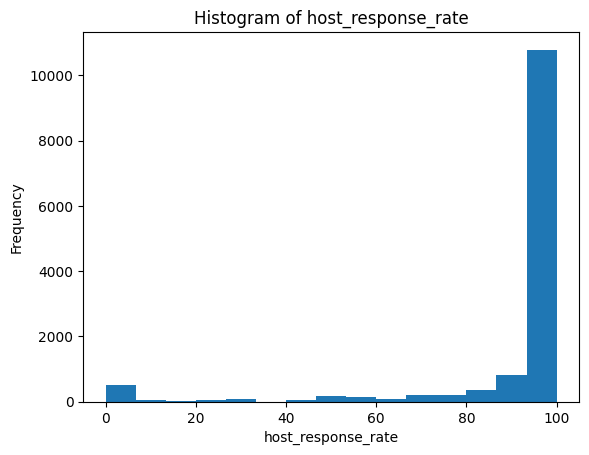

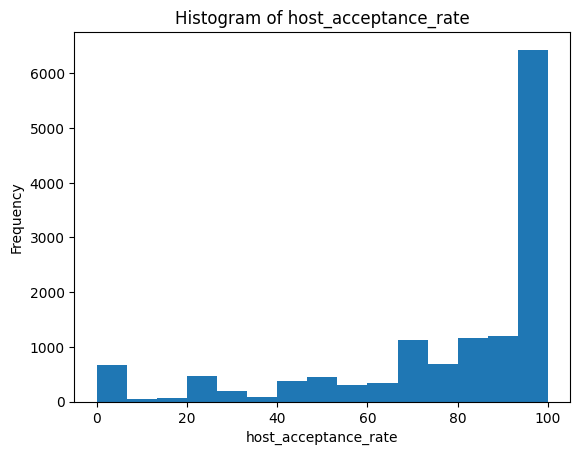

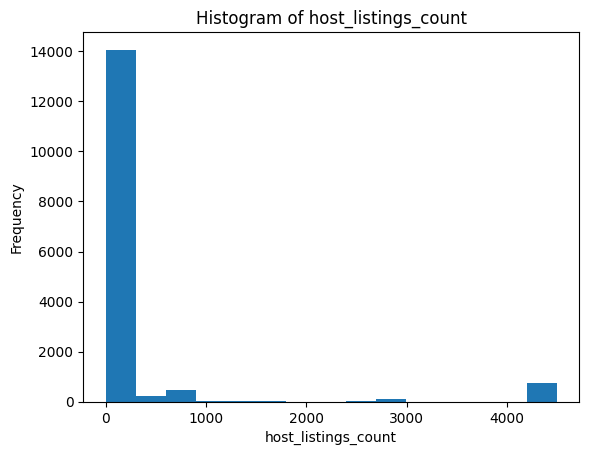

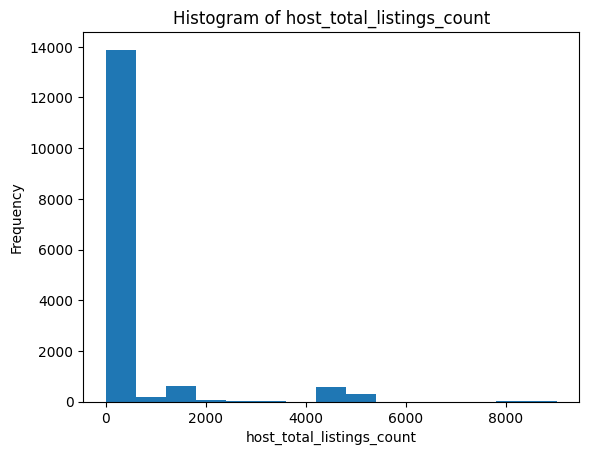

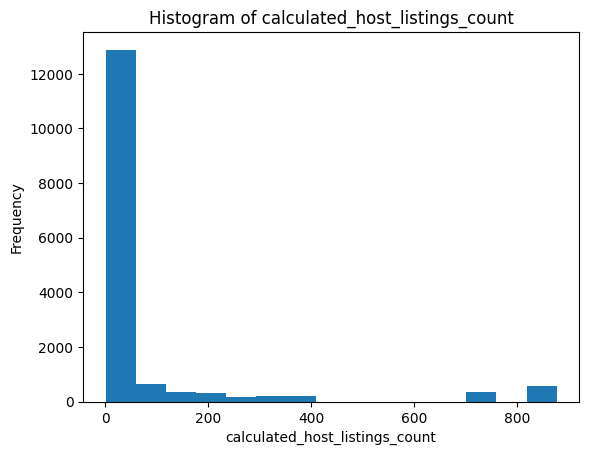

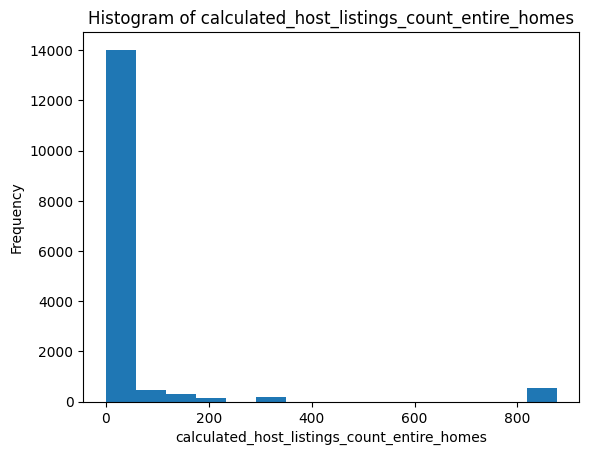

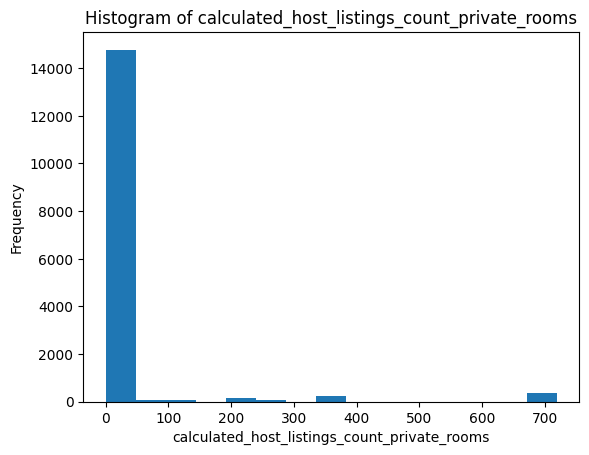

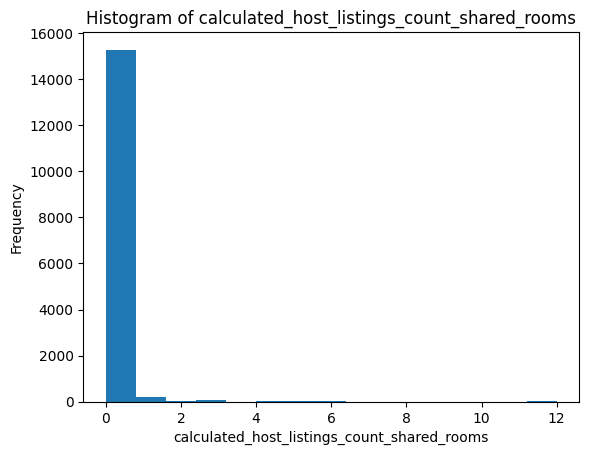

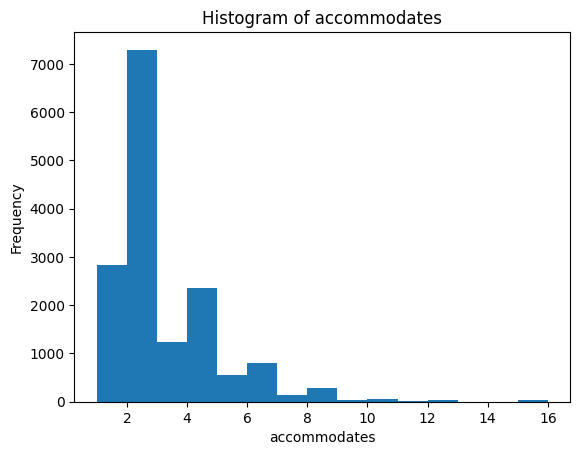

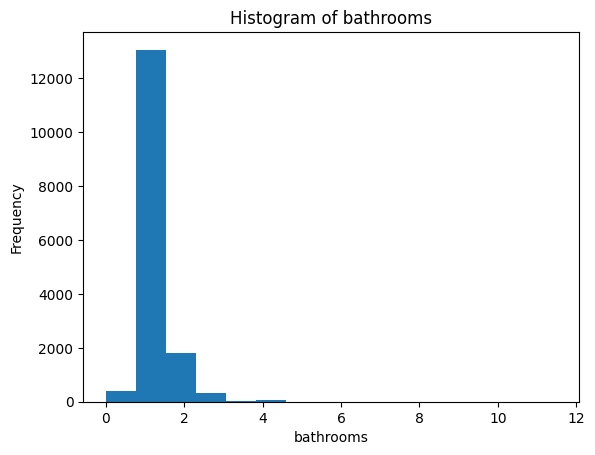

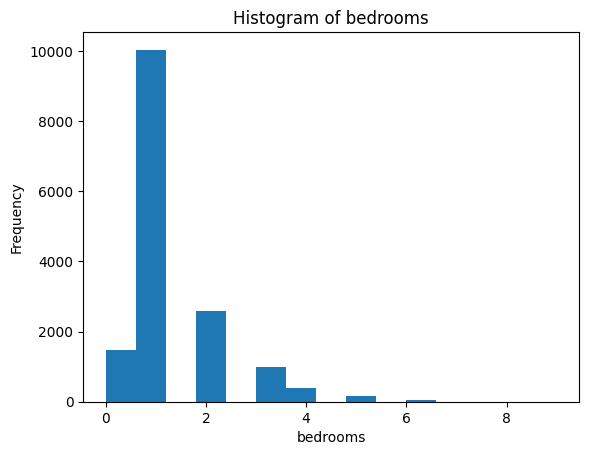

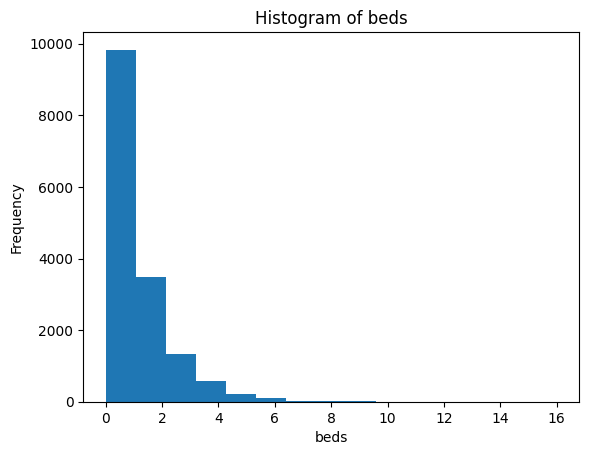

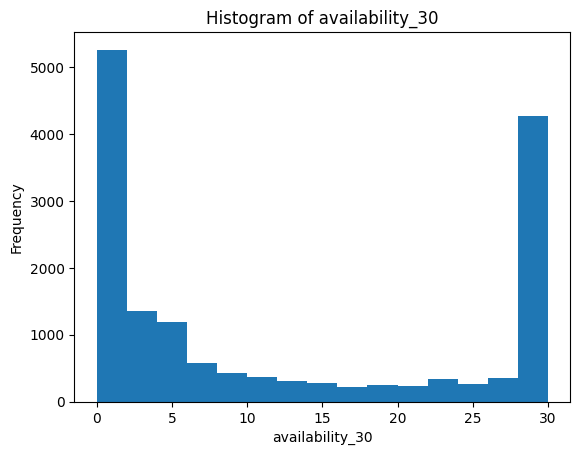

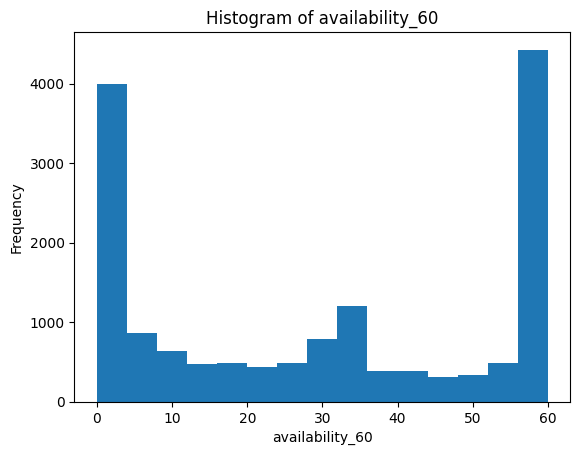

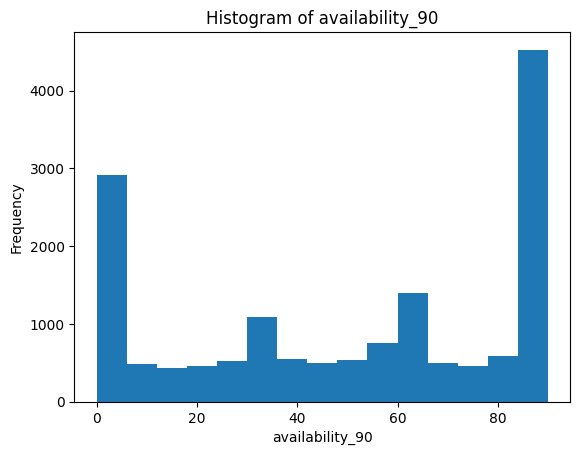

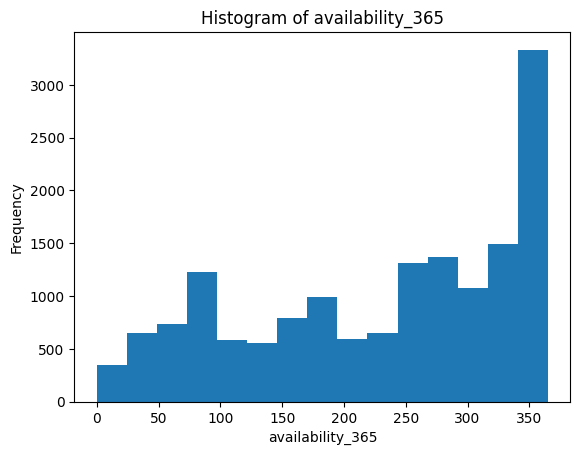

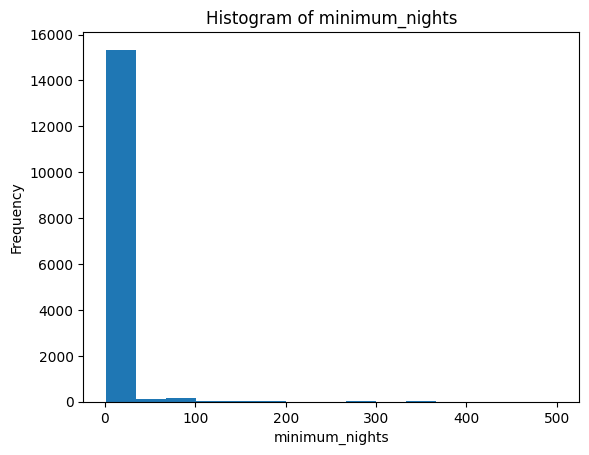

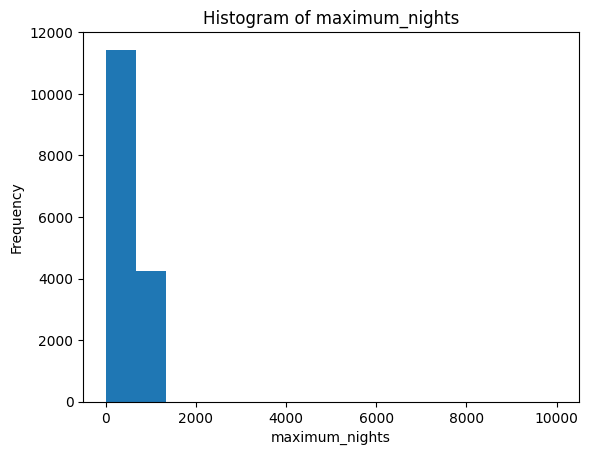

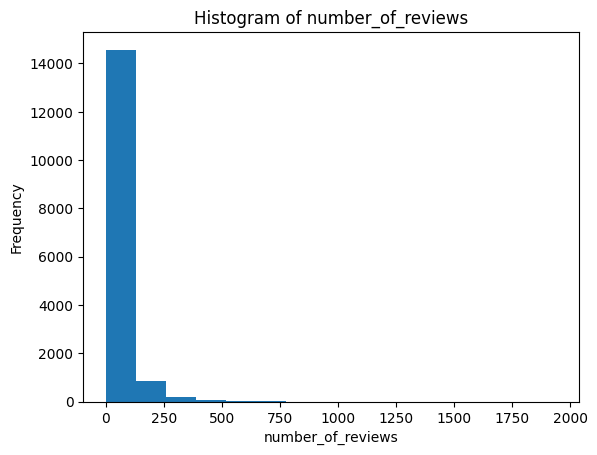

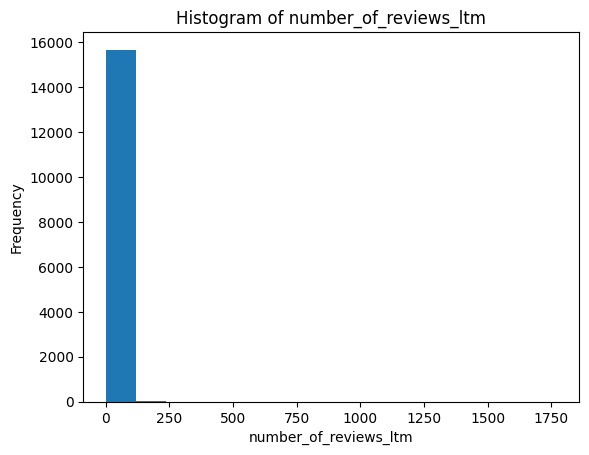

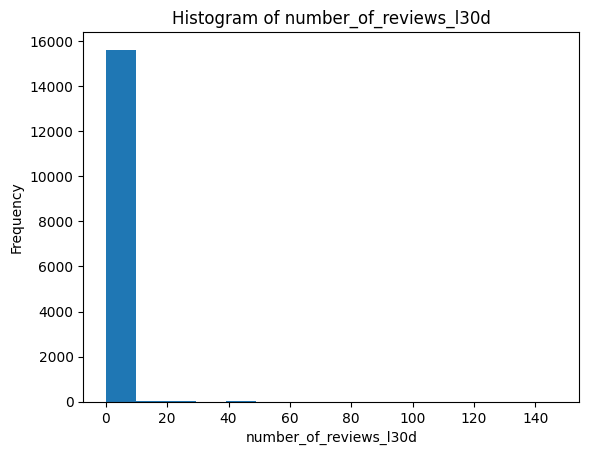

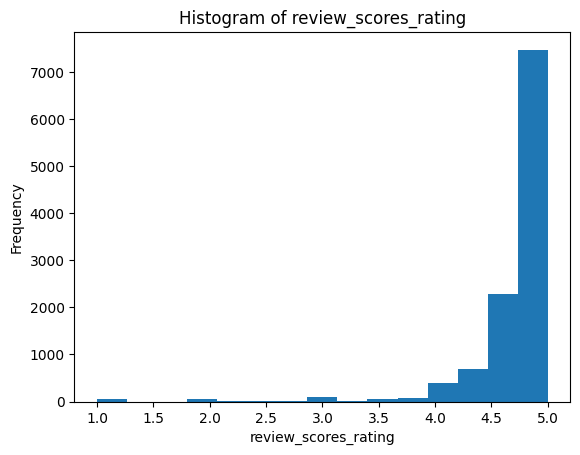

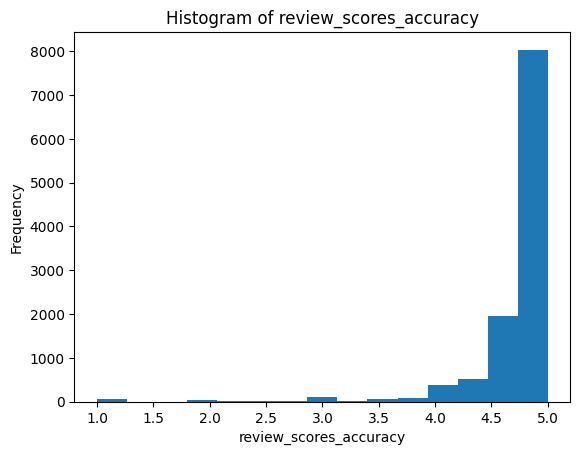

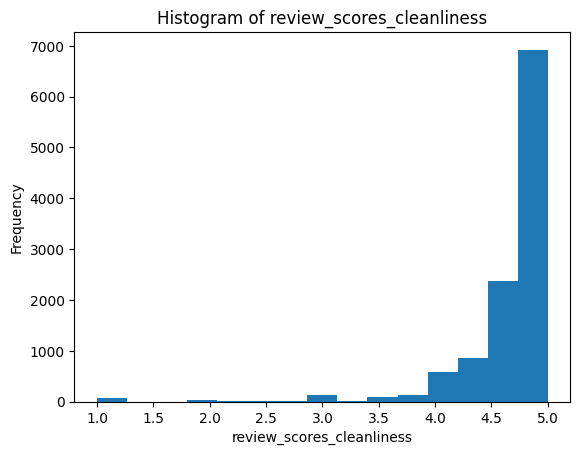

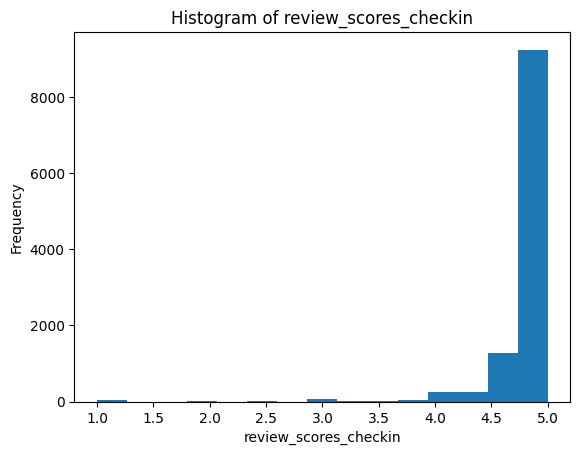

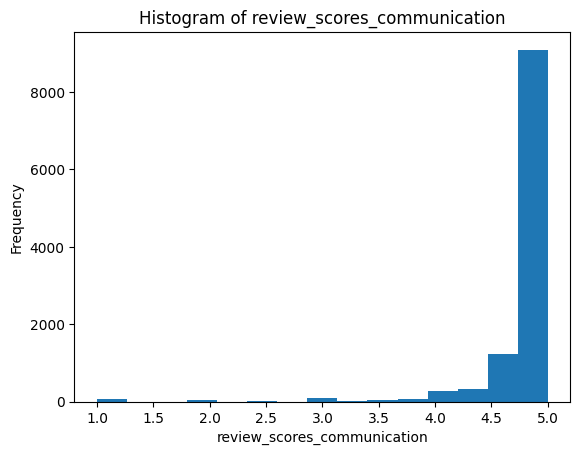

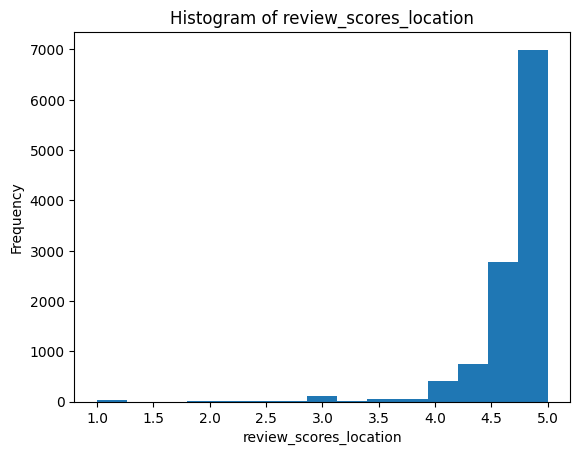

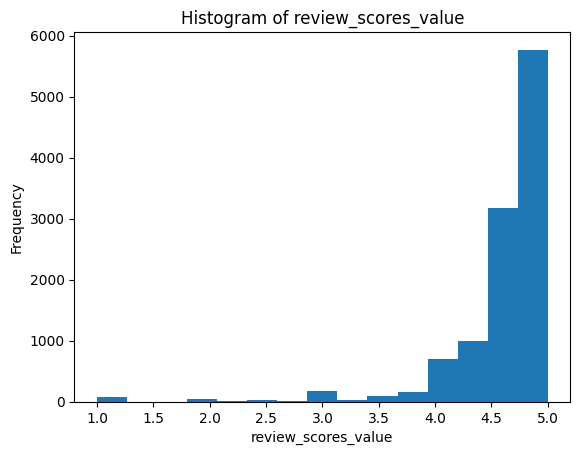

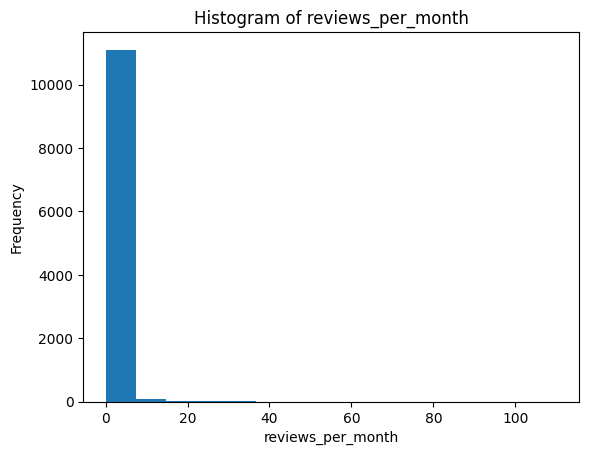

C:\Users\zakkh\AppData\Local\Temp\ipykernel_56856\890811122.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


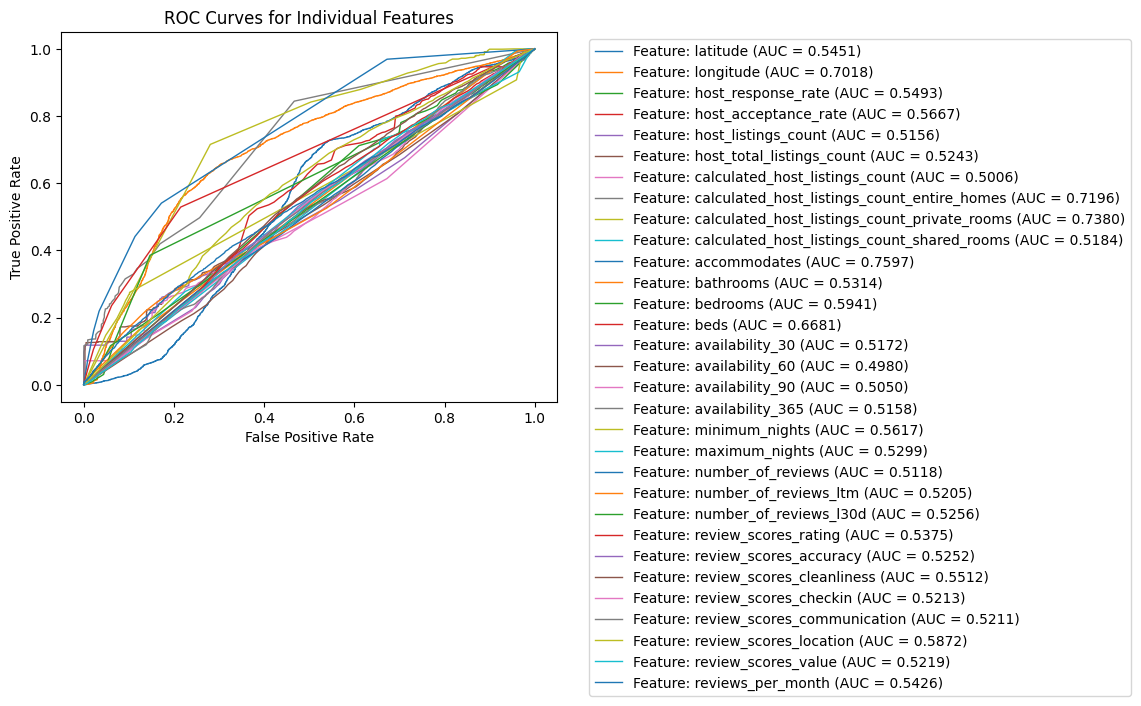

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("Data/train.csv")
data['price'] = pd.to_numeric(data['price'], errors='coerce')

y = data['price']
X = data.drop(columns=['price'])

print("X shape:", X.shape)
print("y shape:", y.shape)

numerical_data = data.select_dtypes(include=['float64', 'int64'])
numerical_features = numerical_data.columns

for feature in list(numerical_features):
    plt.hist(data[feature].dropna(), bins=15)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

summary_stats = pd.DataFrame({
    "Min": numerical_data.min(),
    "Mean": numerical_data.mean(),
    "Median": numerical_data.median(),
    "Max": numerical_data.max()
})

summary_stats

y_variant = y.map(lambda x: 0 if x in [0, 1, 2] else 1)
scaler = StandardScaler()

for feature in [f for f in numerical_features if f != 'price']:
    valid_data = data[[feature]].dropna()
    y_variant_valid = y_variant.loc[valid_data.index]

    X_scaled = scaler.fit_transform(valid_data)
        
    model = LogisticRegression()
    model.fit(X_scaled, y_variant_valid)

    y_scores = model.predict_proba(X_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_variant_valid, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'Feature: {feature} (AUC = {roc_auc:.4f})')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [57]:
beds_less_than_bedrooms = X[X['beds'] < X['bedrooms']]
print("Rows where beds are less than bedrooms:")
print(beds_less_than_bedrooms[['accommodates', 'beds', 'bedrooms', 'bathrooms']])

not_less_beds_to_bedrooms = X[X['beds'] >= X['bedrooms']]
not_less_avg_ratio = (not_less_beds_to_bedrooms['bedrooms'] / not_less_beds_to_bedrooms['beds']).mean()
print(f"Average ratio of bedrooms to beds for rows where beds are not less than bedrooms: {not_less_avg_ratio:.2f}")

Rows where beds are less than bedrooms:
       accommodates  beds  bedrooms  bathrooms
3                 1   1.0       4.0        1.5
10                1   1.0       4.0        0.0
22                1   1.0       4.0        0.0
27                1   1.0       6.0        2.0
46                1   1.0       4.0        0.0
...             ...   ...       ...        ...
15559             6   1.0       2.0        1.0
15568             1   1.0       3.0        0.0
15572             1   1.0       4.0        0.0
15581             2   0.0       1.0        2.0
15673             1   1.0       4.0        0.0

[1007 rows x 4 columns]
Average ratio of bedrooms to beds for rows where beds are not less than bedrooms: 0.80


In [58]:
import re

import warnings
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")

def do_preprocessing(X, impute_from):
    unique_entries = X['host_response_time'].unique()
    #print("Unique entries in host_response_time:", unique_entries) # nan values but this may mean something - maybe they're new users so I lean towards not imputing
    unique_entries = X['property_type'].unique()
    #print("Unique entries in property_type:", unique_entries) 
    unique_entries = X['neighbourhood_cleansed'].unique()
    #print("Unique entries in neighbourhood_cleansed:", unique_entries) 
    unique_entries = X['neighbourhood_group_cleansed'].unique()
    #print("Unique entries in neighbourhood_group_cleansed:", unique_entries) 
    unique_entries = X['room_type'].unique()
    #print("Unique entries in room_type:", unique_entries) 
    unique_entries = X['bathrooms_text'].unique()
    #print("Unique entries in bathrooms_text:", unique_entries) 

    #def map_bathrooms_text_to_int(entry):
    #    if pd.isna(entry): return -1
    #    if "half-bath" in entry.lower(): return 0.5
    #   return float(entry.split()[0])

    X["shared_baths"] = X["bathrooms_text"].apply(lambda x: "shared" in str(x).lower()).astype(int)
    #X['bathrooms_text_int'] = X['bathrooms_text'].apply(map_bathrooms_text_to_int) # kill this, redundant
    X = X.drop(columns=['bathrooms_text']) # we already have bathrooms numerical

    def rotate_coordinates(X):
        # Process each angle
        for angle in [20, 45, 60, 80]:
            angle_radians = np.radians(angle)
            rotation_matrix = np.array([
                [np.cos(angle_radians), -np.sin(angle_radians)],
                [np.sin(angle_radians),  np.cos(angle_radians)]
            ])
            
            coords = np.stack((X['longitude'], X['latitude']), axis=-1)
            rotated_coords = np.dot(coords, rotation_matrix.T)
            
            X[f'rotated_lat_{angle}'] = rotated_coords[:, 1]
            X[f'rotated_lng_{angle}'] = rotated_coords[:, 0]
        
        return X
    
    X = rotate_coordinates(X)

    def map_host_response_time_to_int(entry):
        if pd.isna(entry): return 5 # probably on the later side / never responds side of the spectrum
        elif entry.lower() == "within an hour": return 1
        elif entry.lower() == "within a few hours": return 2
        elif entry.lower() == "within a day": return 3
        elif entry.lower() == "a few days or more": return 4
        else: return 5

    X['host_response_time_int'] = X['host_response_time'].apply(map_host_response_time_to_int)
    X = X.drop(columns=['host_response_time'])


    #X['amenities_list'] = X['amenities'].replace('[', '').replace(']', '').replace('"', '').apply(lambda x: x.split(', ') if pd.notna(x) else [])

    #all_amenities = set(amenity for amenities in X['amenities_list'] for amenity in amenities) # do something better

    #for amenity in all_amenities:
    #    X[f'amenity_{amenity}'] = X['amenities_list'].apply(lambda x: 1 if amenity in x else 0)

    #X = X.drop(columns=['amenities', 'amenities_list'])

    reference_date = pd.Timestamp('2000-01-01')

    for column in ['host_since', 'first_review', 'last_review']:
        X[column] = pd.to_datetime(X[column], errors='coerce')
        X[f'{column}_days_since_2000'] = (X[column] - reference_date).dt.days
        X[f'{column}_days_since_2000'] = X[f'{column}_days_since_2000'].fillna(366*25)

    X = X.drop(columns=['host_since', 'first_review', 'last_review']) 

    #def extract_minutes(text):
    #    if not isinstance(text, str): return np.nan
    #    match = re.search(r'(\d+)\s*(min|minutes?)', text, re.IGNORECASE)
    #    return int(match.group(1)) if match else np.nan

    def extract_square_footage(text):
        if not isinstance(text, str): return np.nan
        match = re.search(r'(\d+)\s*(square[\s-]?f)', text, re.IGNORECASE)
        return int(match.group(1)) if match else np.nan

    #X['extracted_minutes'] = X['name'].apply(extract_minutes) # we already have location data, neighborhood, we don't need this
    #X['extracted_minutes'].fillna(X['description'].apply(extract_minutes), inplace=True)
    #X['extracted_minutes'].fillna(X['reviews'].apply(extract_minutes), inplace=True)
    #X['extracted_minutes'].fillna(-10, inplace=True)

    # comment out? not a great predictor because of how much is missing
    #X['extracted_sqf'] = X['name'].apply(extract_square_footage)
    #X['extracted_sqf'].fillna(X['description'].apply(extract_square_footage), inplace=True)
    #X['extracted_sqf'].fillna(X['reviews'].apply(extract_square_footage), inplace=True)
    #X['extracted_sqf'].fillna(-1000, inplace=True) # there is enough missing that it may be worth making another category


    X = X.drop(columns=['reviews', 'name', 'description'])

    #X = X.drop(columns=['host_identity_verified', 'host_has_profile_pic', 'host_verifications'])
    X = X.drop(columns=['host_verifications']) # not that important and would turn into multiple features

    #numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

    missing_counts = X.isnull().sum()
    #print(missing_counts[missing_counts > 0])

    X['host_response_rate'] = X['host_response_rate'].fillna(-10) # they're likely missing not at random but not sure why. Likely options are not enough messages in.
    X['host_acceptance_rate'] = X['host_acceptance_rate'].fillna(-10) # maybe they've never accepted anyone?

    X['has_availability'] = X['has_availability'].fillna(False) # there are no false values before imputing so na must be false
    X['host_is_superhost'] = X['host_is_superhost'].fillna('Other') # we don't act on host_is_superhost, leave it a 3rd category because it doesn't seem like they're all False (e.g. not enough data), a lot of observations have good reviews and such but are missing this.
    #X['host_is_superhost'] = X['host_is_superhost'].fillna(False)
    X = pd.get_dummies(X, columns=['host_is_superhost'], drop_first=True)

    X['proportion_homes'] = X['calculated_host_listings_count_entire_homes'] /X['calculated_host_listings_count']
    X['proportion_private_rooms'] = X['calculated_host_listings_count_private_rooms']/X['calculated_host_listings_count']
    X['proportion_shared_rooms'] = X['calculated_host_listings_count_shared_rooms']/X['calculated_host_listings_count']


    # All that is being done here is assigning the median, but if it is not an integer, round it to an integer in the direction of the mean. 
    mean_bedrooms = impute_from['bedrooms'].mean()
    median_bedrooms = impute_from['bedrooms'].median()
    if median_bedrooms > mean_bedrooms:
        imput_bedrooms = int(median_bedrooms)
    else:
        imput_bedrooms = int(median_bedrooms) + 1
    X['bedrooms'] = X['bedrooms'].fillna(imput_bedrooms)

    mean_bathrooms = impute_from['bathrooms'].mean()
    median_bathrooms = impute_from['bathrooms'].median()
    if median_bathrooms > mean_bathrooms:
        imput_bathrooms = int(median_bathrooms)
    else:
        imput_bathrooms = int(median_bathrooms) + 1
    X['bathrooms'] = X['bathrooms'].fillna(imput_bathrooms)

    def fill_beds_from_bedrooms(row, data):
        if pd.isnull(row['beds']):
            matching_bathrooms = data[data['bedrooms'] == row['bedrooms']]
            most_frequent_bedroom = matching_bathrooms['beds'].mode()
            return most_frequent_bedroom.iloc[0] if not most_frequent_bedroom.empty else None
        return row['beds']

    X['beds'] = X.apply(lambda row: fill_beds_from_bedrooms(row, X), axis=1) # highly related covariates, might as well just take the most common.

    X.loc[X['beds'] < X['bedrooms'], 'beds'] = X.loc[X['beds'] < X['bedrooms'], 'bedrooms'] / 0.8 # 1000 observations in the training data have fewer beds than bedrooms. while this could be because of office spaces, I believe it is a data entry error (given just how far off some are), so we replace it with the average multiplicative difference between the two (calculated based on the training data)
    
    nothing = [ # these are all missing for the same reason - they have no reviews, but that is more important than setting than to 0 - it needs distinction
        'review_scores_rating',
        'review_scores_accuracy',
        'review_scores_cleanliness',
        'review_scores_checkin',
        'review_scores_communication',
        'review_scores_location',
        'review_scores_value'
    ]
    X[nothing] = X[nothing].fillna(-1)
    X['reviews_per_month'] = X['reviews_per_month'].fillna(0) # missing for the same reason, but it does have literally 0 in this

    missing_data = X.isna().sum()
    missing_columns = missing_data[missing_data > 0]
    if not missing_columns.empty: print("Columns with remaining NaN values: \n", missing_columns)
    else: print("No NaN values remaining in the dataset.")

    #unique_entries = X['host_is_superhost'].unique()
    #print("Unique entries in host_is_superhost:", unique_entries) 

    unique_entries = X['has_availability'].unique()
    #print("Unique entries in has_availability:", unique_entries) 

    def add_avg_price_columns(X, impute_from):
        # avg_price_neighbourhood_cleansed and avg_price_neighbourhood_group_cleansed - look in the impute_from dataset
        # in the neighbourhood_cleansed and neighbourhood_group_cleansed columns and then take the average of the price column and save it. 
        # also, another one avg_price_adjusted_neighbourhood_group and avg_price_adjusted_neighbourhood which scales that figure by the ratio of bedrooms+bathrooms in their house to the average in the neighbourhood.

        avg_price_neighbourhood = impute_from.groupby('neighbourhood_cleansed')['price'].mean()
        X['avg_price_neighbourhood_cleansed'] = X['neighbourhood_cleansed'].map(avg_price_neighbourhood).fillna(-1)

        avg_price_group = impute_from.groupby('neighbourhood_group_cleansed')['price'].mean()
        X['avg_price_neighbourhood_group_cleansed'] = X['neighbourhood_group_cleansed'].map(avg_price_group).fillna(-1)

        avg_features_neighbourhood = impute_from.groupby('neighbourhood_cleansed').apply(
            lambda df: (df['bedrooms'].fillna(0) + df['bathrooms'].fillna(0)).mean()
        )
        X['avg_features_neighbourhood'] = X['neighbourhood_cleansed'].map(avg_features_neighbourhood).fillna(-1)

        X['avg_price_adjusted_neighbourhood'] = X.apply(
            lambda row: row['avg_price_neighbourhood_cleansed'] *
            ((row['bedrooms'] + row['bathrooms']) /
            avg_features_neighbourhood.get(row['neighbourhood_cleansed'], -1))
            if row['avg_price_neighbourhood_cleansed'] != -1 and avg_features_neighbourhood.get(row['neighbourhood_cleansed'], -1) > 0 else -1,
            axis=1
        )

        avg_features_group = impute_from.groupby('neighbourhood_group_cleansed').apply(
            lambda df: (df['bedrooms'].fillna(0) + df['bathrooms'].fillna(0)).mean()
        )
        X['avg_features_neighbourhood_group'] = X['neighbourhood_group_cleansed'].map(avg_features_group).fillna(-1)

        X['avg_price_adjusted_neighbourhood_group'] = X.apply(
            lambda row: row['avg_price_neighbourhood_group_cleansed'] *
            ((row['bedrooms'] + row['bathrooms']) /
            avg_features_group.get(row['neighbourhood_group_cleansed'], -1))
            if row['avg_price_neighbourhood_group_cleansed'] != -1 and avg_features_group.get(row['neighbourhood_group_cleansed'], -1) > 0 else -1,
            axis=1
        )

        #X = X.drop(columns=['avg_features_neighbourhood', 'avg_features_neighbourhood_group']) # we will allow it to use these in decision-making

        return X

    #X = add_avg_price_columns(X, impute_from)
    #X = pd.get_dummies(X, columns=['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type'], drop_first=True)

    def add_knn_avg_prices(X, impute_from):
        impute_lat_lon = impute_from[['latitude', 'longitude']].values
        impute_prices = impute_from['price'].values

        X['avg_price_3_closest'] = -1
        X['avg_price_5_closest'] = -1
        X['avg_price_10_closest'] = -1
        X['avg_price_20_closest'] = -1
        X['avg_price_3_closest'] = X['avg_price_3_closest'].astype(float)
        X['avg_price_5_closest'] = X['avg_price_5_closest'].astype(float)
        X['avg_price_10_closest'] = X['avg_price_10_closest'].astype(float)
        X['avg_price_20_closest'] = X['avg_price_20_closest'].astype(float)

        for i, row in X.iterrows():
            distances = np.sqrt(
                (row['latitude'] - impute_lat_lon[:, 0])**2 +
                (row['longitude'] - impute_lat_lon[:, 1])**2
            )

            # exclude identical points geographically if datasets are the same size (meaning I am imputing train with train and getting the same house)
            if len(X) == len(impute_from):
                distances[i] = np.inf
            
            closest_indices = np.argsort(distances)

            closest_3_prices = impute_prices[closest_indices[:3]]
            closest_5_prices = impute_prices[closest_indices[:5]]
            closest_10_prices = impute_prices[closest_indices[:10]]
            closest_20_prices = impute_prices[closest_indices[:20]]

            X.at[i, 'avg_price_3_closest'] = np.mean(closest_3_prices)
            X.at[i, 'avg_price_5_closest'] = np.mean(closest_5_prices)
            X.at[i, 'avg_price_10_closest'] = np.mean(closest_10_prices)
            X.at[i, 'avg_price_20_closest'] = np.mean(closest_20_prices)

        return X
    
    #X = add_knn_avg_prices(X, impute_from)

    return pd.get_dummies(X, columns=['property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type'], drop_first=True), X

X, X_before_one_hot_encoding = do_preprocessing(X, pd.concat([X, y], axis=1))
# In Sandbox, impute the layer 2 train (layer 1 validation) with the layer 1 train, and impute the layer 2 test with the layer 1 train, imputing the layer 1 train with itself
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)
# X_layer1, X_layer2, y_layer1, y_layer2 = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# X_layer1 = do_preprocessing(X_layer1, X_layer1)
# X_test = do_preprocessing(X_test, X_layer1)
# X_layer2 = do_preprocessing(X_layer2, X_layer1)
# Comment out the data splits that will override this when running

No NaN values remaining in the dataset.


In [59]:
import ast
import string

def everything_amenities(X):
    # name, inclusion criteria (one of), exclusion criteria (one of)
    # e.g. pool is different than pool table
    case1 = True
    if case1:
        amenities_keywords = {
            "Conditioner/soap/shampoo": (["conditioner", "soap", "shampoo", "irish spring"], []),
            "Toaster oven": (["toaster oven"], []),
            "Oven": (["oven"], ["toaster"]),
            "Wifi": (["wifi"], []),
            "HDTV/TV/Television": (["hdtv", "tv", "television"], []),
            "Sound system/smart speaker/subwoofer": (["sound system", "smart speaker", "subwoofer"], []),
            "Hair dryer": (["hair dryer"], []),
            "Dryer": (["dryer"], []),
            "Washer": (["washer"], []),
            "Essentials": (["essentials"], []),
            "Refrigerator": (["refrigerator"], []),
            "French press": (["french press"], []),
            "Housekeeping": (["housekeeping"], []),
            "Free parking or carport": (["free parking", "carport"], []),
            "Parking (without 'free')": (["parking"], ["free"]),
            "Outdoor kitchen": (["outdoor kitchen"], []),
            "Shades": (["shades"], []),
            "Crib": (["crib"], []),
            "Bowling alley": (["bowling alley"], []),
            "Board games": (["board games"], []),
            "Induction stove/cooktop": (["induction stove", "induction cooktop"], []),
            "Gas stove": (["gas stove"], []),
            "Electric stove": (["electric stove"], []),
            "Other Stove": (["stove"], ["electric", "gas", "induction"]),
            "Gym": (["gym"], []),
            "Spa (without soap/shampoo/conditioner)": (["spa"], ["soap", "shampoo", "conditioner"]),
            "Smart": (["smart"], []),
            "Backyard": (["backyard"], []),
            "Marina": (["marina"], []),
            "Mosquito net": (["mosquito net"], []),
            "Shared patio/balcony": (["shared patio", "shared balcony"], []),
            "Microwave": (["microwave"], []),
            "Fire extinguisher": (["fire extinguisher"], []),
            "Outdoor dining": (["outdoor dining"], []),
            "Grill": (["grill"], []),
            "Shared": (["shared"], ["patio", "balcony"]),
            "Console": (["console"], []),
            "Yoga": (["yoga"], []),
            "Coffee": (["coffee"], []),
            "Indoor Fireplace": (["indoor fireplace"], []),
            "Private pool/pool (without 'table')": (["private pool", "pool"], ["table"]),
            "Pool table": (["pool table"], []),
            "Sauna": (["sauna"], []),
            "Valet": (["valet"], []),
            "Kettle": (["kettle"], []),
            "Bidet": (["bidet"], []),
            "Smoking allowed": (["smoking allowed"], []),
            "Dining table": (["dining table"], []),
            "Arcade": (["arcade"], []),
            "Lockbox": (["lockbox"], []),
            "Hot tub": (["hot tub"], []),
            "Trash compactor": (["trash compactor"], []),
            "Security cameras": (["security cameras"], []),
            "Heater": (["heater"], []),
            "Garage": (["garage"], []),
            "Piano": (["piano"], []),
            "Outdoor shower": (["outdoor shower"], []),
            "Pets allowed": (["pets allowed"], []),
            "Treadmill/workout bench": (["treadmill", "workout bench"], []),
            "Harbor": (["harbor"], []),
            "Sun loungers": (["sun loungers"], []),
            "Private entrance": (["private entrance"], []),
            "Batting cage": (["batting cage"], []),
            "City skyline": (["city skyline"], []),
            "Air conditioning": (["air conditioning"], []),
            "Bike": (["bike"], []),
            "Hot water": (["hot water"], []),
            "Breakfast": (["breakfast"], []),
            "Valley view": (["valley view"], []),
            "Resort": (["resort"], []),
            "Waterfront": (["waterfront"], []),
            "Elevator": (["elevator"], []),
            "Lake": (["lake"], []),
            "Beach or Ocean": (["beach", "ocean"], []),
            "Golf course": (["golf course"], []),
            "Movie theater": (["movie theater"], []),
        }

        def encode_amenities(amenities, include_keywords, exclude_keywords): # for a row, there are many amenities, but this is processing them per entry in the amenities list. e.g. pool and table are separate ideas in separate entries if there is a pool and a table, but a pool table in one entry is treated differently.
            for item in ast.literal_eval(amenities):
                if any(inc in item.lower() for inc in include_keywords):
                    if not any(exc in item.lower() for exc in exclude_keywords):
                        return 1 # inclusion and exclusion met
            return 0

        for amenity, (include_keywords, exclude_keywords) in amenities_keywords.items():
            print(amenity)
            X[amenity] = X['amenities'].apply(lambda amenities: encode_amenities(amenities, include_keywords, exclude_keywords)) # for each amenity, if one entry in the list satisfies it...

        X = X.drop(columns=['amenities'])

        return X
    
    else:
        X['amenities_list'] = X['amenities'].replace('[', '').replace(']', '').replace('"', '').apply(lambda x: x.split(', ') if pd.notna(x) else [])

        all_amenities = set(amenity for amenities in X['amenities_list'] for amenity in amenities) # do something better

        for amenity in all_amenities:
            X[f'amenity_{amenity}'] = X['amenities_list'].apply(lambda x: 1 if amenity in x else 0)

        X = X.drop(columns=['amenities', 'amenities_list'])

        return X


X = everything_amenities(X)

Conditioner/soap/shampoo
Toaster oven
Oven
Wifi
HDTV/TV/Television
Sound system/smart speaker/subwoofer
Hair dryer
Dryer
Washer
Essentials
Refrigerator
French press
Housekeeping
Free parking or carport
Parking (without 'free')
Outdoor kitchen
Shades
Crib
Bowling alley
Board games
Induction stove/cooktop
Gas stove
Electric stove
Other Stove
Gym
Spa (without soap/shampoo/conditioner)
Smart
Backyard
Marina
Mosquito net
Shared patio/balcony
Microwave
Fire extinguisher
Outdoor dining
Grill
Shared
Console
Yoga
Coffee
Indoor Fireplace
Private pool/pool (without 'table')
Pool table
Sauna
Valet
Kettle
Bidet
Smoking allowed
Dining table
Arcade
Lockbox
Hot tub
Trash compactor
Security cameras
Heater
Garage
Piano
Outdoor shower
Pets allowed
Treadmill/workout bench
Harbor
Sun loungers
Private entrance
Batting cage
City skyline
Air conditioning
Bike
Hot water
Breakfast
Valley view
Resort
Waterfront
Elevator
Lake
Beach or Ocean
Golf course
Movie theater


In [60]:
#print(X)

for f in X.columns:
    print(f)

latitude
longitude
host_response_rate
host_acceptance_rate
host_listings_count
host_total_listings_count
host_has_profile_pic
host_identity_verified
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
accommodates
bathrooms
bedrooms
beds
has_availability
availability_30
availability_60
availability_90
availability_365
instant_bookable
minimum_nights
maximum_nights
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
reviews_per_month
shared_baths
rotated_lat_20
rotated_lng_20
rotated_lat_45
rotated_lng_45
rotated_lat_60
rotated_lng_60
rotated_lat_80
rotated_lng_80
host_response_time_int
host_since_days_since_2000
first_review_days_since_2000
last_review_days_since_2000
host_is_superhost_True
host_is_superh

In [61]:
for column in X.columns:
    print(f"{column}: {(X[column] == 1).sum()}")

latitude: 0
longitude: 0
host_response_rate: 0
host_acceptance_rate: 0
host_listings_count: 4801
host_total_listings_count: 2840
host_has_profile_pic: 15305
host_identity_verified: 14397
calculated_host_listings_count: 5599
calculated_host_listings_count_entire_homes: 4359
calculated_host_listings_count_private_rooms: 2747
calculated_host_listings_count_shared_rooms: 202
accommodates: 2833
bathrooms: 12364
bedrooms: 10031
beds: 8879
has_availability: 15578
availability_30: 666
availability_60: 311
availability_90: 156
availability_365: 15
instant_bookable: 3728
minimum_nights: 1532
maximum_nights: 1
number_of_reviews: 1279
number_of_reviews_ltm: 2060
number_of_reviews_l30d: 1518
review_scores_rating: 58
review_scores_accuracy: 68
review_scores_cleanliness: 62
review_scores_checkin: 41
review_scores_communication: 59
review_scores_location: 35
review_scores_value: 74
reviews_per_month: 207
shared_baths: 4042
rotated_lat_20: 0
rotated_lng_20: 0
rotated_lat_45: 0
rotated_lng_45: 0
rotated

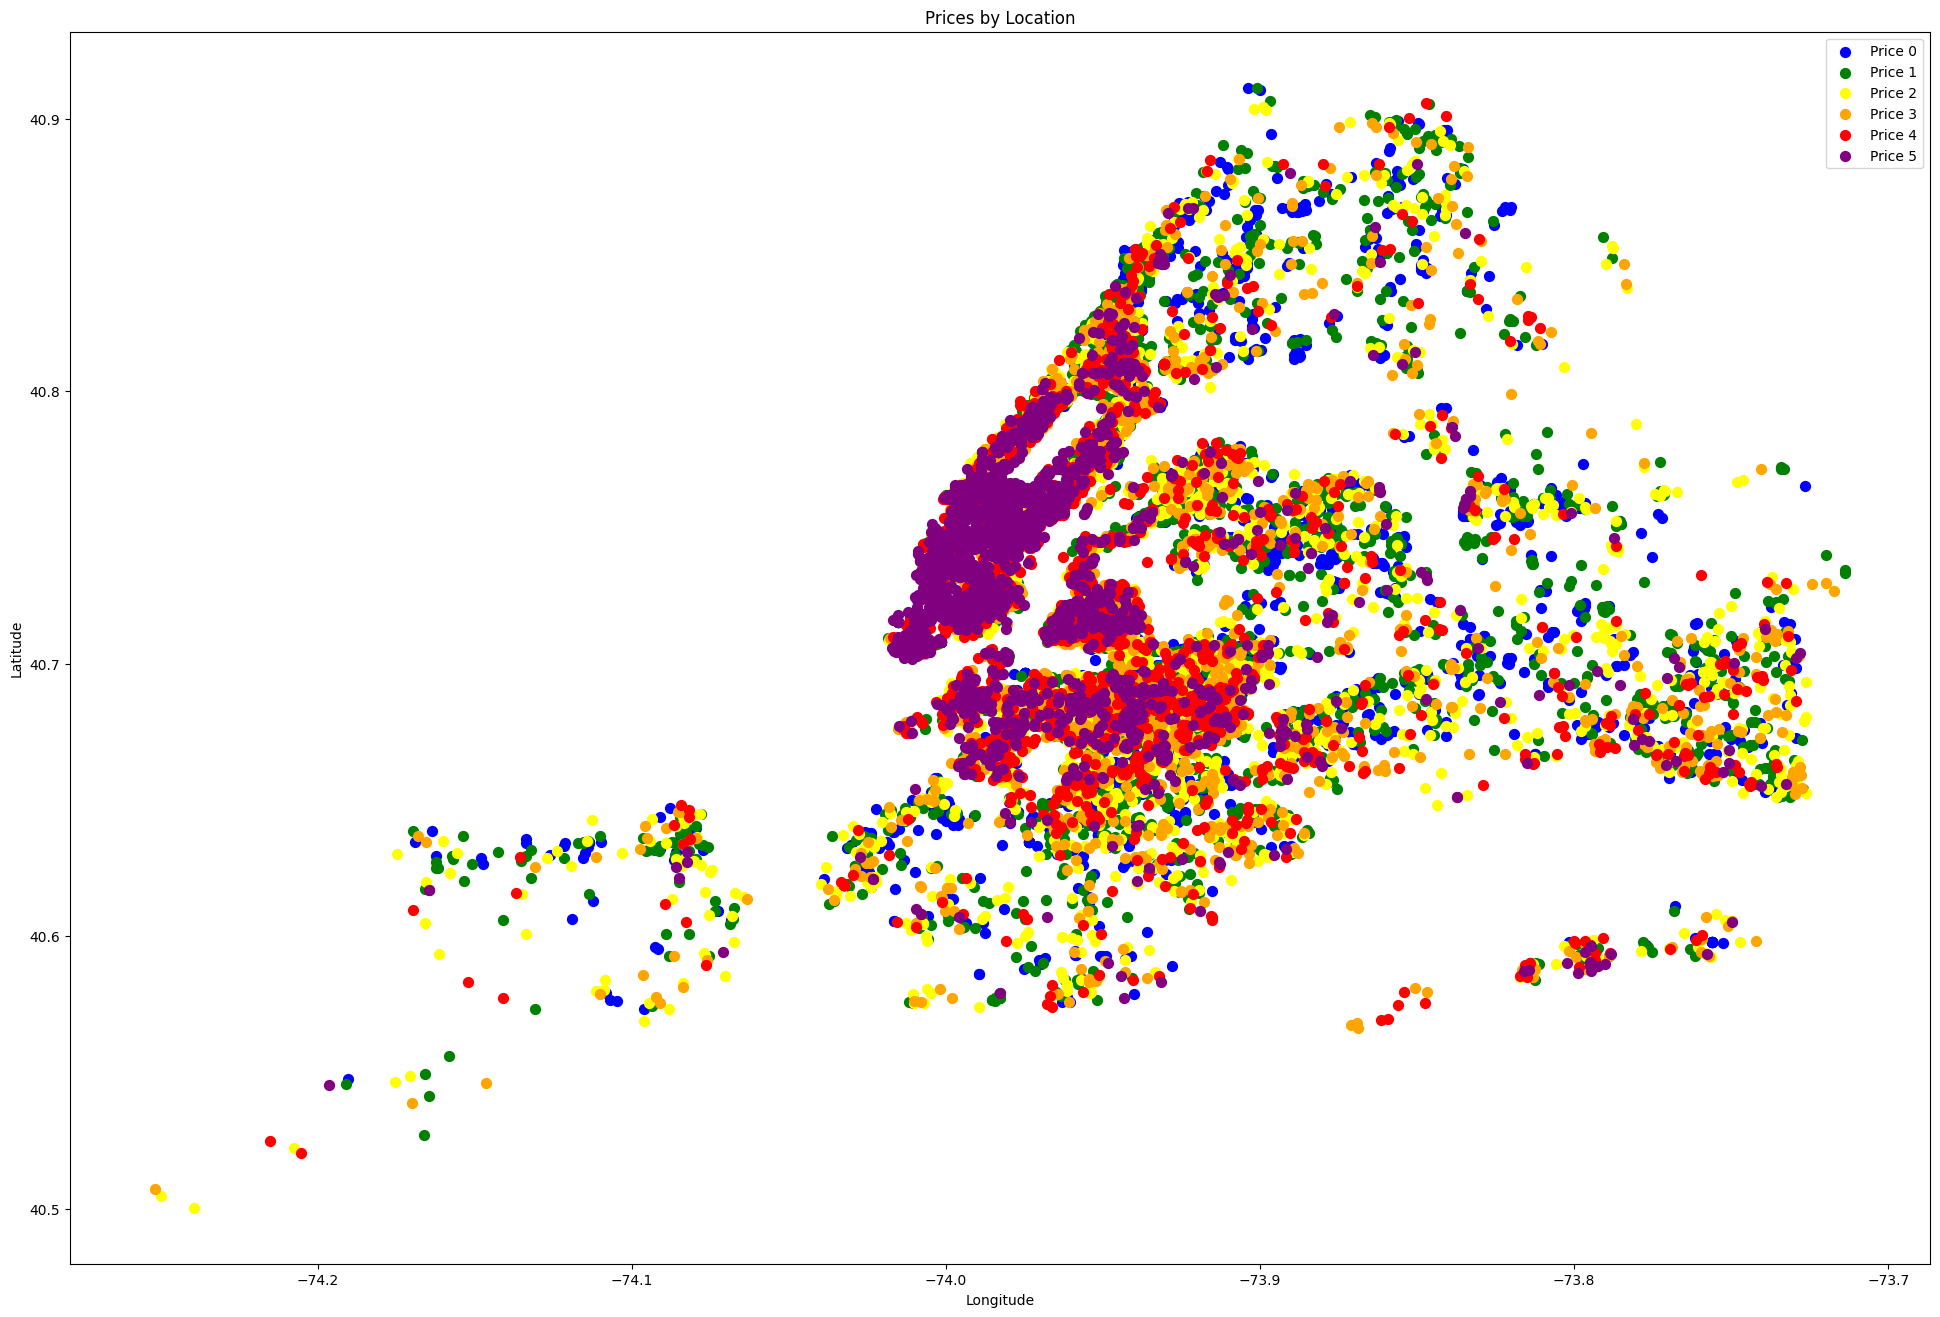

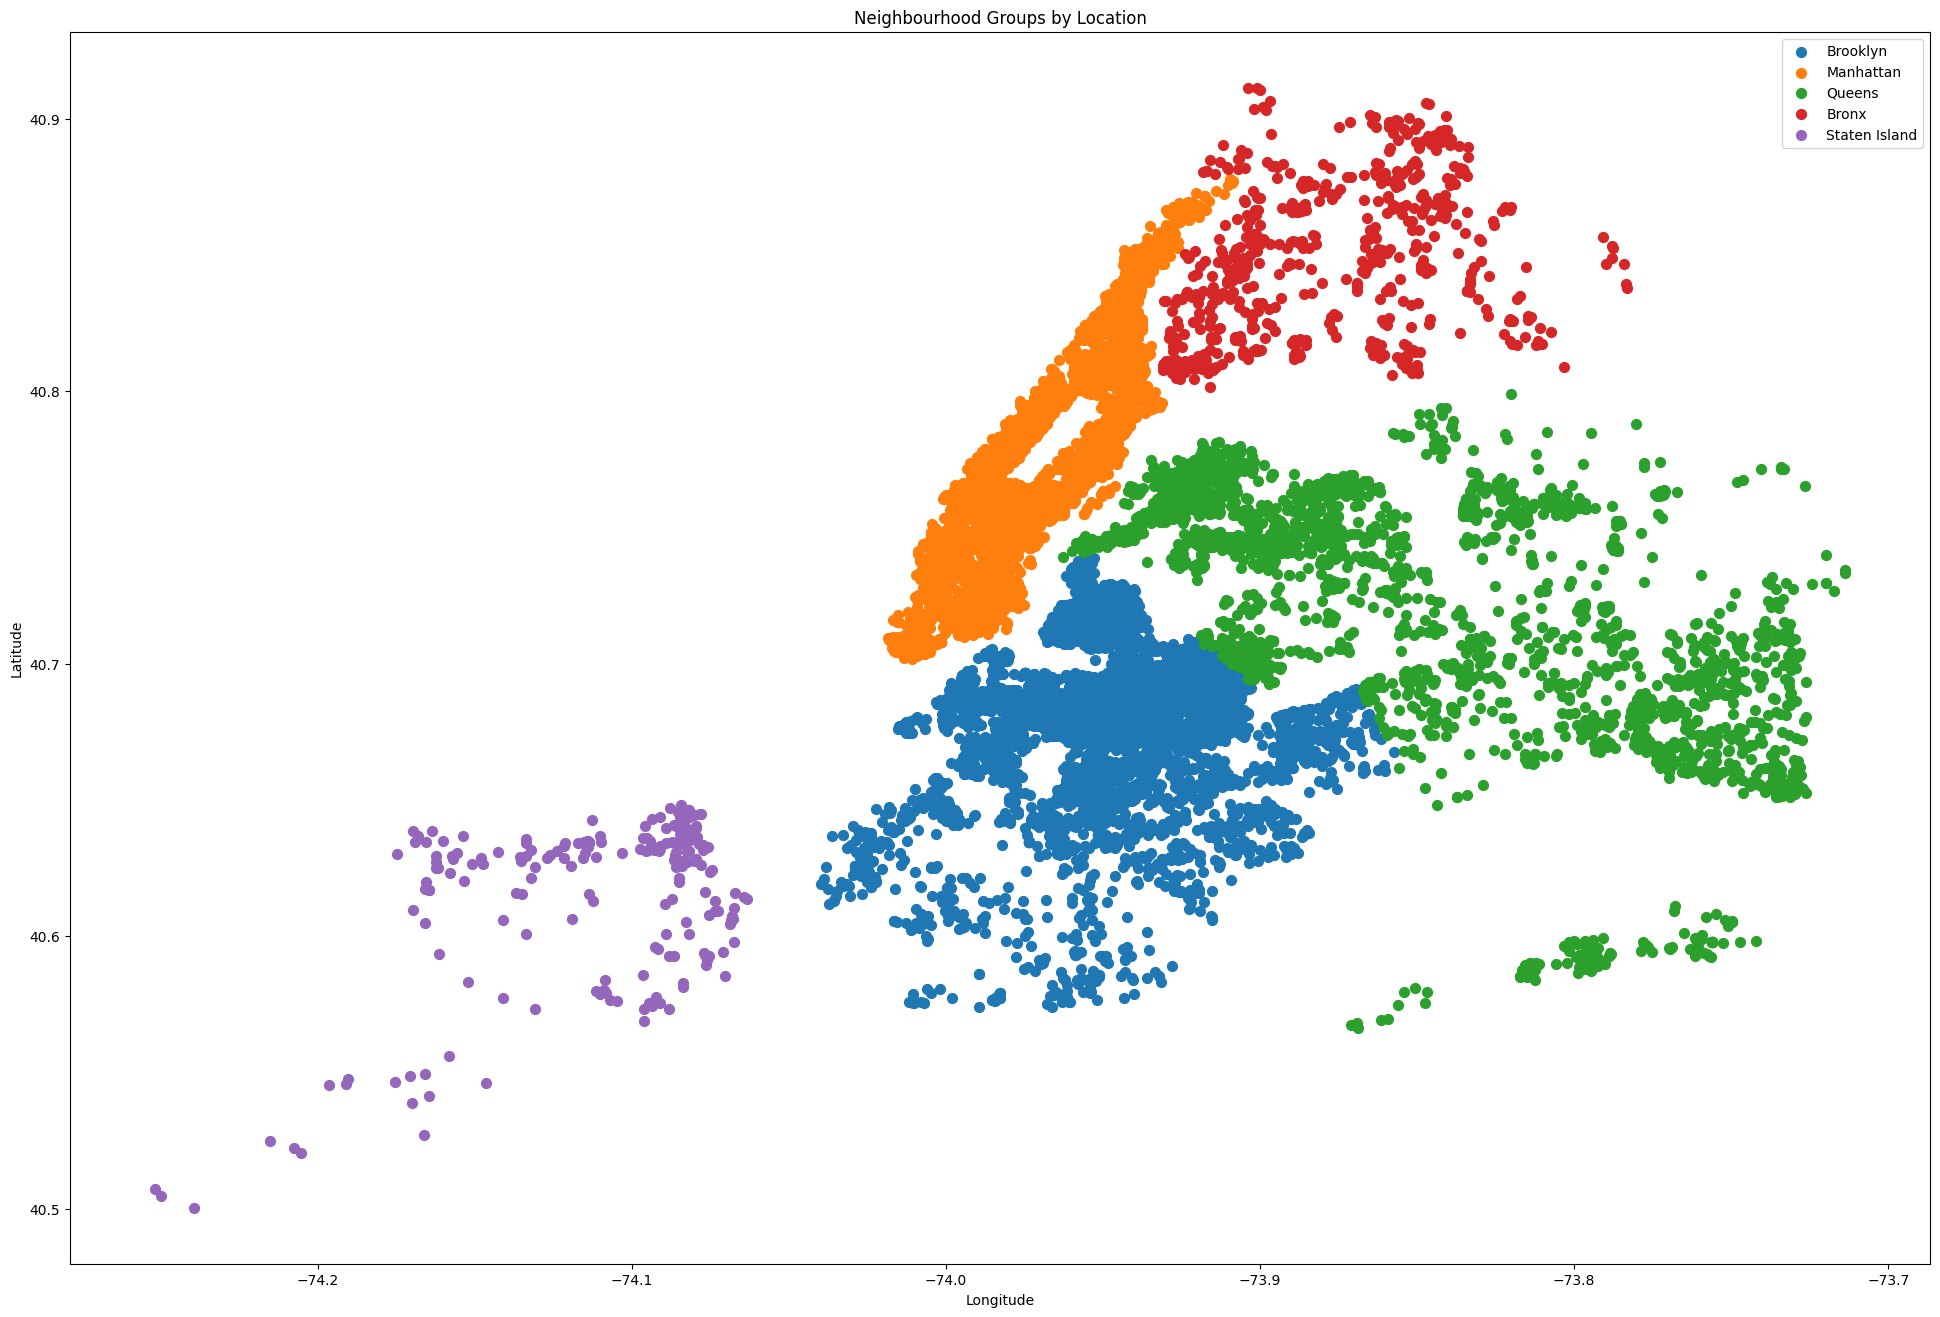

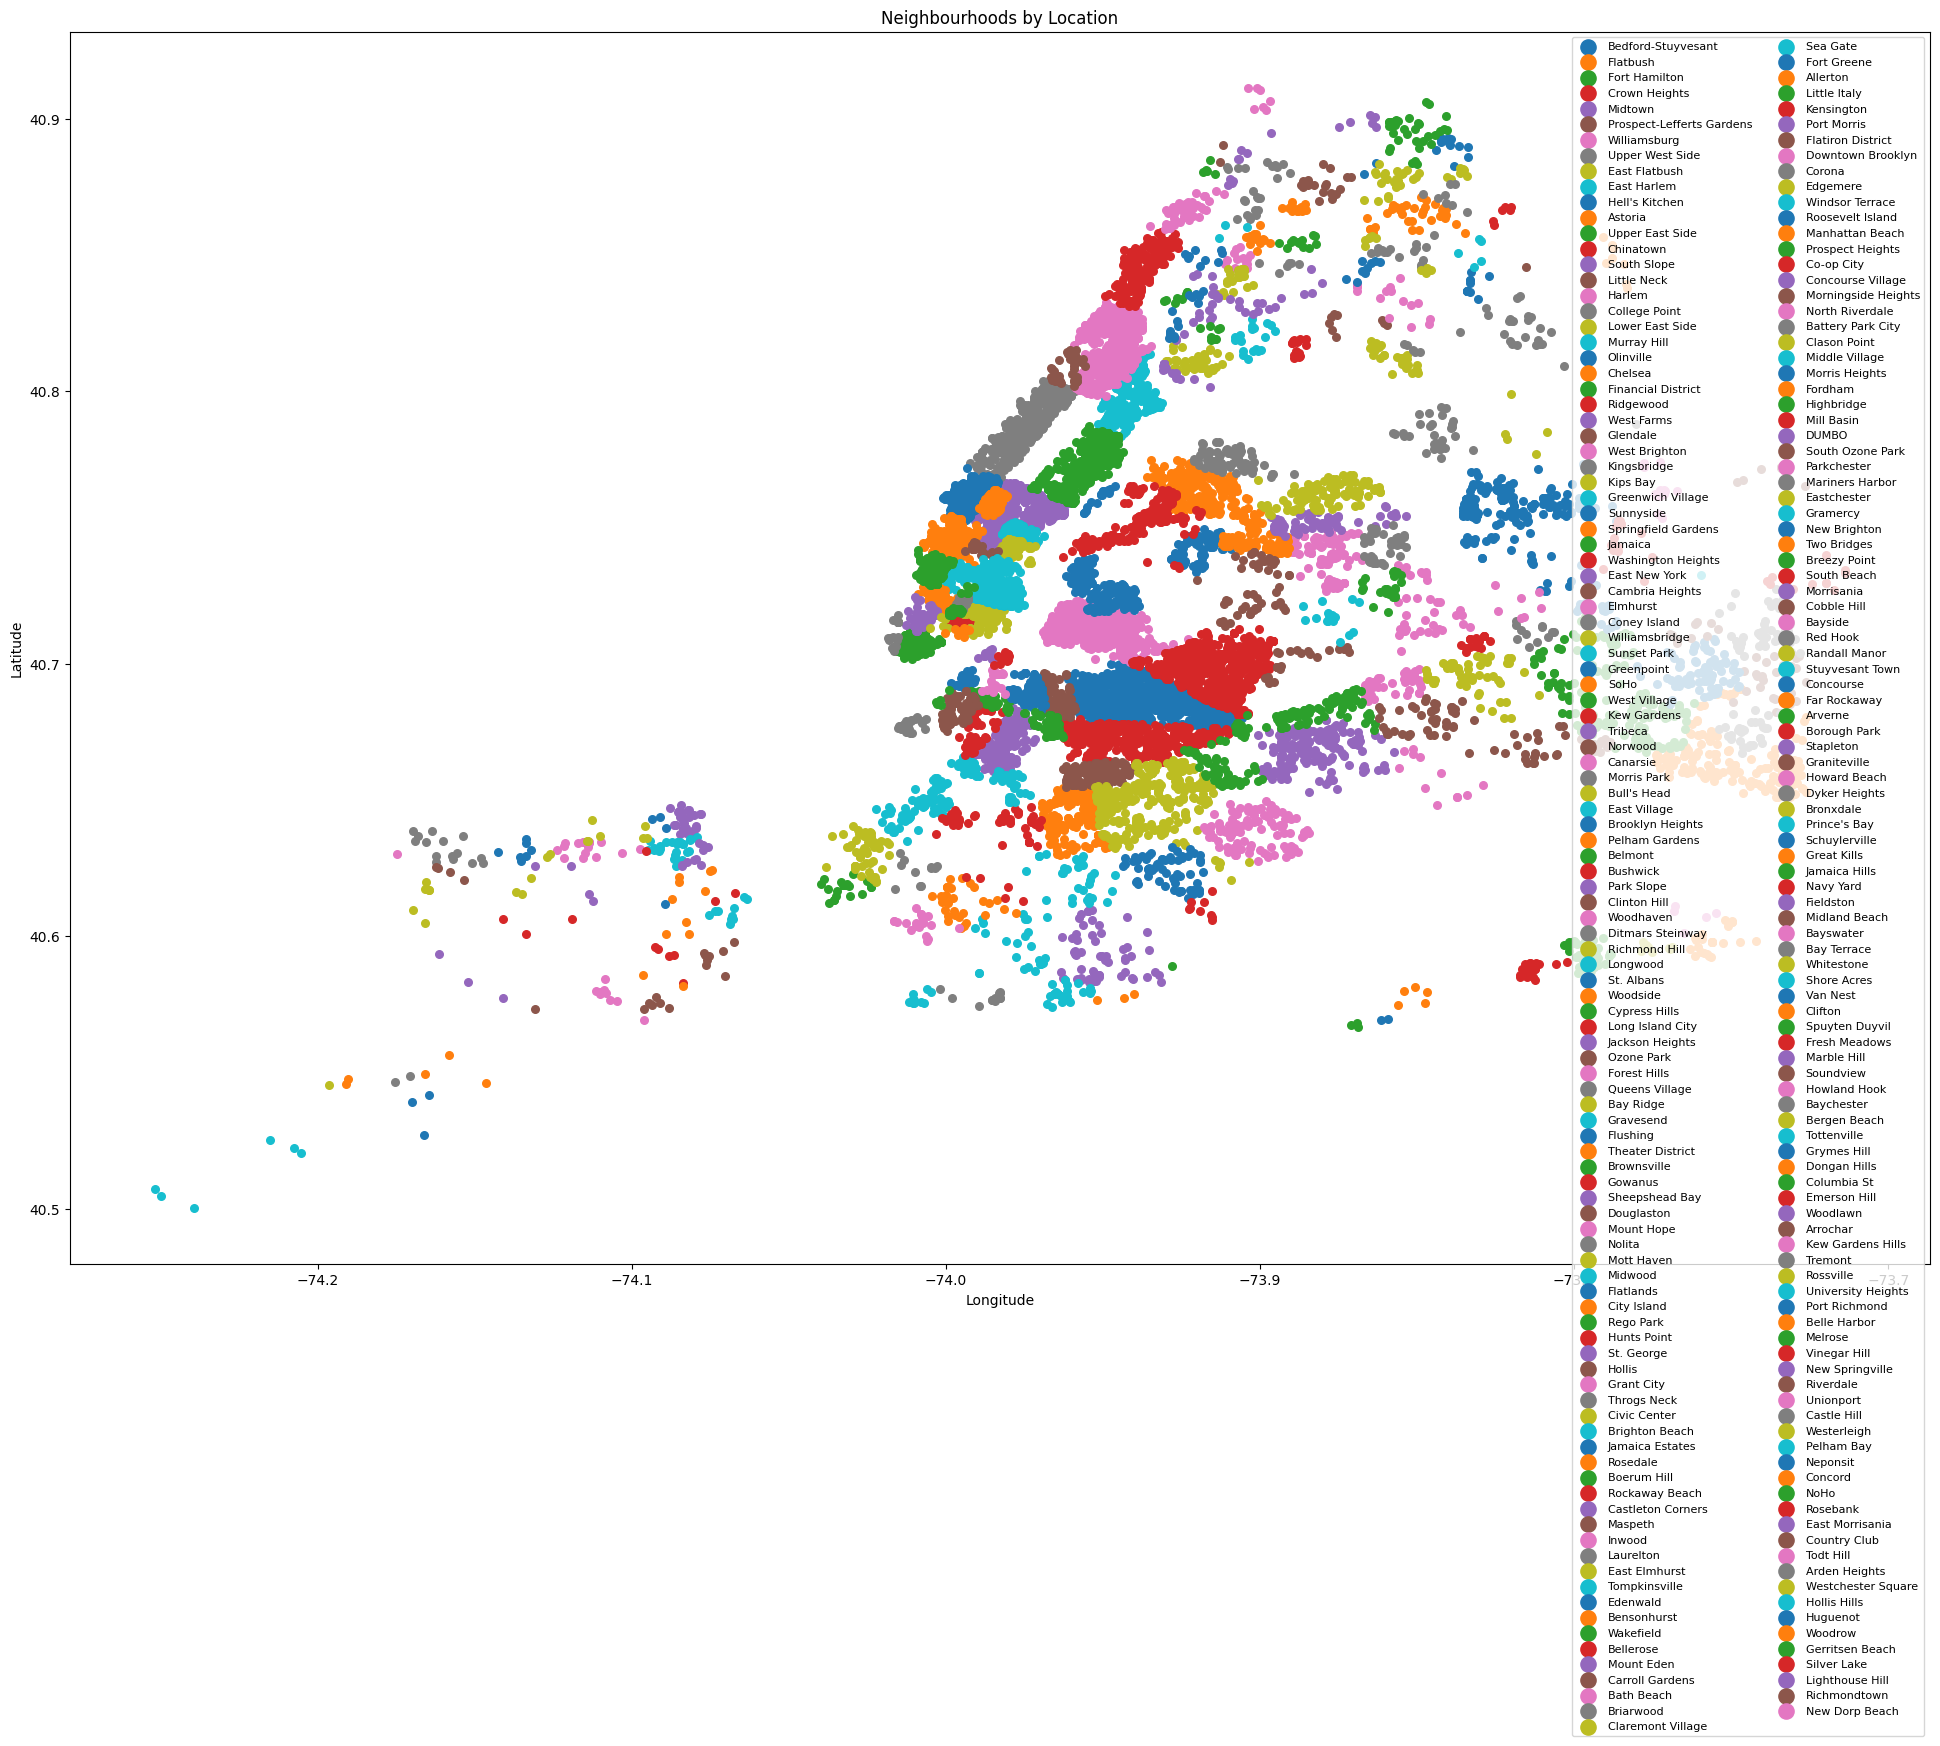

In [62]:
Full = pd.concat([X, y.rename('price')], axis=1)

colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple']

plt.figure(figsize=(24, 16))

for price_category in range(6):
    subset = Full[Full['price'] == price_category]
    plt.scatter(subset['longitude'],subset['latitude'], color=colors[price_category], label=f'Price {price_category}', s=50)

plt.legend(loc='upper right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prices by Location')
plt.show()

for_mapping = pd.read_csv("Data/train.csv")

unique_groups = for_mapping['neighbourhood_group_cleansed'].unique()

plt.figure(figsize=(24, 16))



for group in unique_groups:
    subset = for_mapping[for_mapping['neighbourhood_group_cleansed'] == group]
    plt.scatter(subset['longitude'], subset['latitude'], label=f'{group}', s=50)

plt.legend(loc='upper right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Neighbourhood Groups by Location')
plt.show()

unique_neighbourhoods = for_mapping['neighbourhood_cleansed'].unique()

plt.figure(figsize=(24, 16))

for neighbourhood in unique_neighbourhoods:
    subset = for_mapping[for_mapping['neighbourhood_cleansed'] == neighbourhood]
    plt.scatter(subset['longitude'], subset['latitude'], label=f'{neighbourhood}', s=30)

plt.legend(loc='upper right', markerscale=2, ncol=2, fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Neighbourhoods by Location')
plt.show()

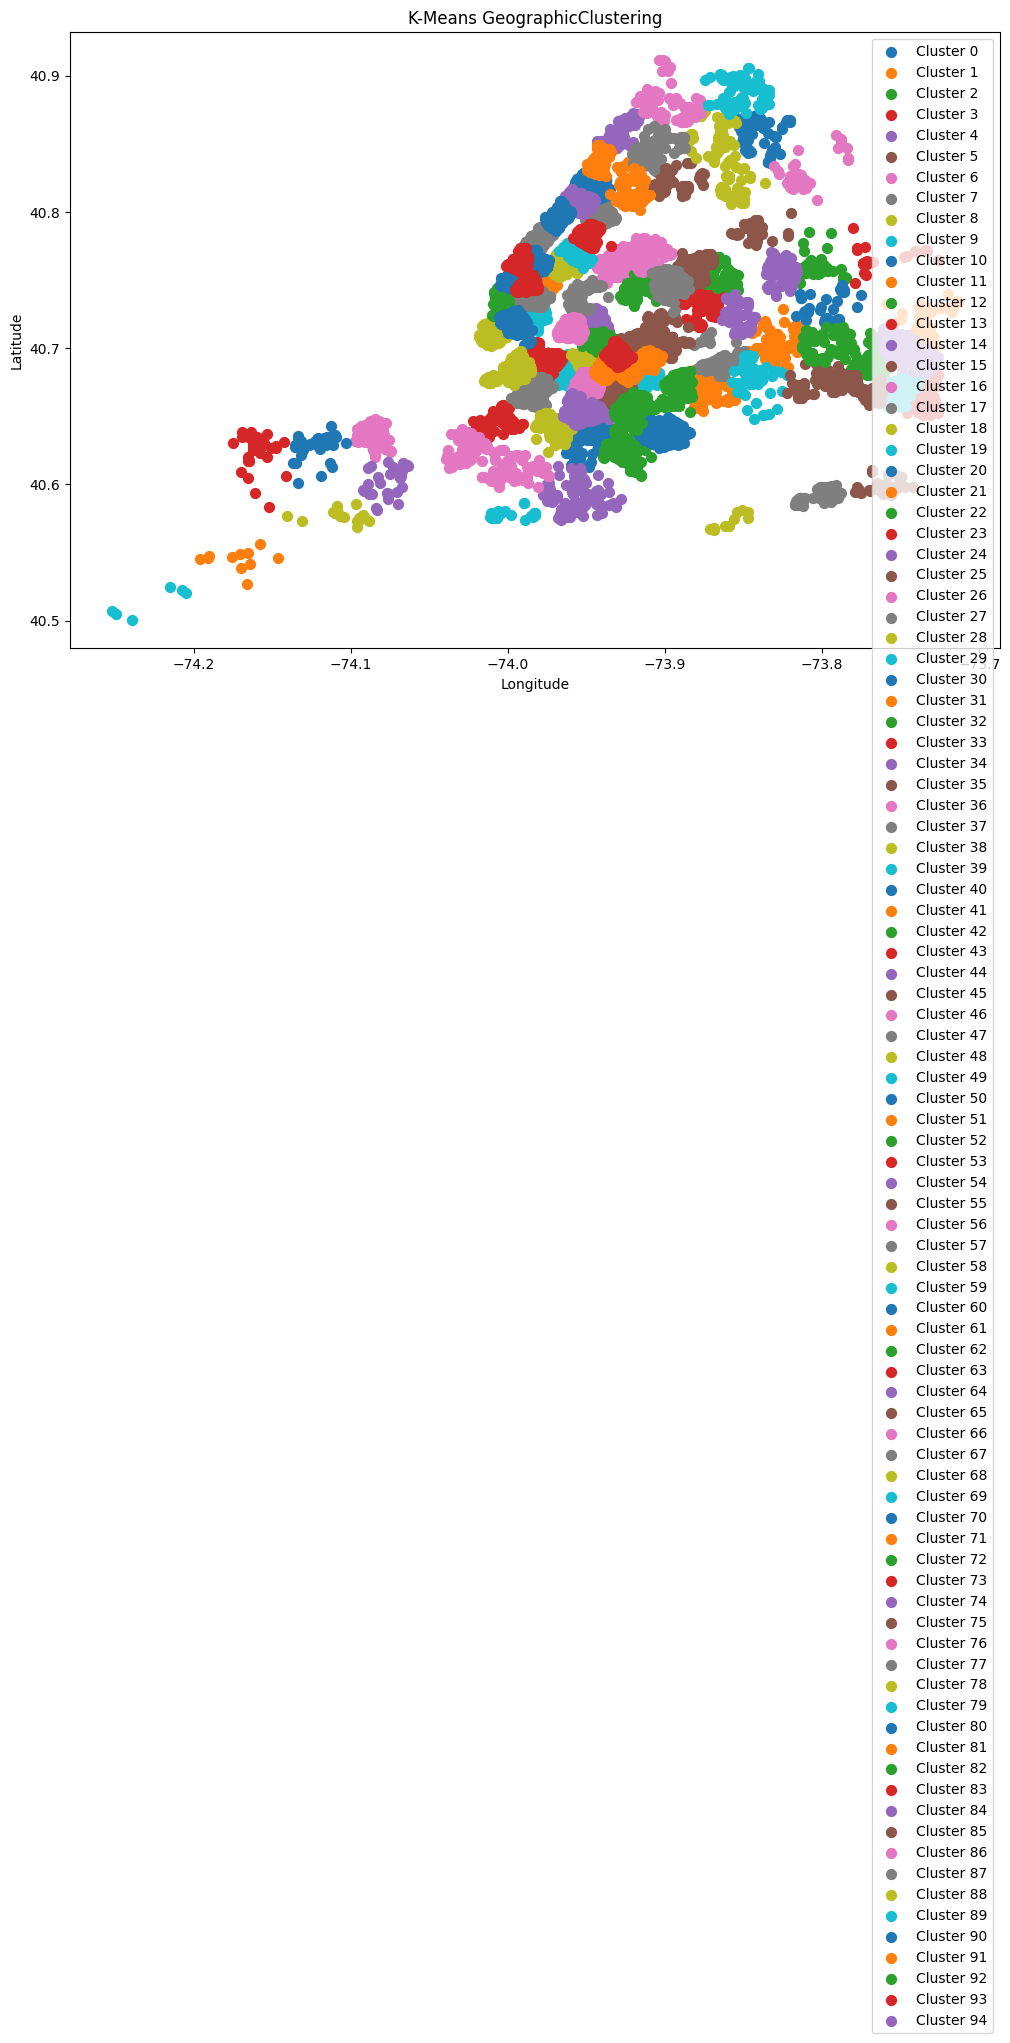

In [63]:
from sklearn.cluster import KMeans

coords = Full[['latitude', 'longitude']].dropna()

count = 95

kmeans = KMeans(n_clusters=count, random_state=42)
clusters = kmeans.fit_predict(coords)

Full['cluster'] = np.nan
Full.loc[coords.index, 'cluster'] = clusters

plt.figure(figsize=(12, 8))
for cluster_label in range(count):
    cluster_subset = Full[Full['cluster'] == cluster_label]
    plt.scatter(cluster_subset['longitude'],cluster_subset['latitude'],label=f'Cluster {cluster_label}', s=50)

plt.legend(loc='upper right')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means GeographicClustering')
plt.show()


In [64]:
real_test = pd.read_csv("Data/test.csv")

missing_values = real_test.isnull().sum()
#print(missing_values)

id = real_test['id']
real_test = real_test.drop(columns=['id'])

real_test, real_test_before_one_hot_encoding = do_preprocessing(real_test, pd.concat([X_before_one_hot_encoding, y], axis=1))
# Copy pasted

missing_values = real_test.isnull().sum()
print(missing_values)

real_test = everything_amenities(real_test)

missing_values = real_test.isnull().sum()
print(missing_values)




No NaN values remaining in the dataset.
latitude                                      0
longitude                                     0
host_response_rate                            0
host_acceptance_rate                          0
host_listings_count                           0
                                             ..
neighbourhood_group_cleansed_Queens           0
neighbourhood_group_cleansed_Staten Island    0
room_type_Hotel room                          0
room_type_Private room                        0
room_type_Shared room                         0
Length: 315, dtype: int64
Conditioner/soap/shampoo
Toaster oven
Oven
Wifi
HDTV/TV/Television
Sound system/smart speaker/subwoofer
Hair dryer
Dryer
Washer
Essentials
Refrigerator
French press
Housekeeping
Free parking or carport
Parking (without 'free')
Outdoor kitchen
Shades
Crib
Bowling alley
Board games
Induction stove/cooktop
Gas stove
Electric stove
Other Stove
Gym
Spa (without soap/shampoo/conditioner)
Smart
Backyard
Marina

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

In [66]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test) 

# logistic_regression = LogisticRegression(max_iter=5000000, solver='lbfgs')
# logistic_regression.fit(X_train_scaled, y_train)

# y_pred = logistic_regression.predict(X_test_scaled)

# y_pred = np.round(y_pred).astype(int)

# mse = mean_squared_error(y_test, y_pred)

# print(mse)

# accuracy = accuracy_score(y_test, y_pred)

# conf_matrix = confusion_matrix(y_test, y_pred)

# print(conf_matrix)

# print(accuracy)

In [67]:
from sklearn.metrics import make_scorer

def rounded_mse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)
    return mean_squared_error(y_true, y_pred_rounded)

rounded_mse_scorer = make_scorer(rounded_mse, greater_is_better=False)


('rf_14', RandomForestRegressor(max_depth=22, max_features=0.8, min_samples_split=8,
                      n_estimators=3200, n_jobs=-1, random_state=42)) RMSE (Unrounded): 0.7339
('rf_14', RandomForestRegressor(max_depth=22, max_features=0.8, min_samples_split=8,
                      n_estimators=3200, n_jobs=-1, random_state=42)) RMSE (rounded): 0.7820


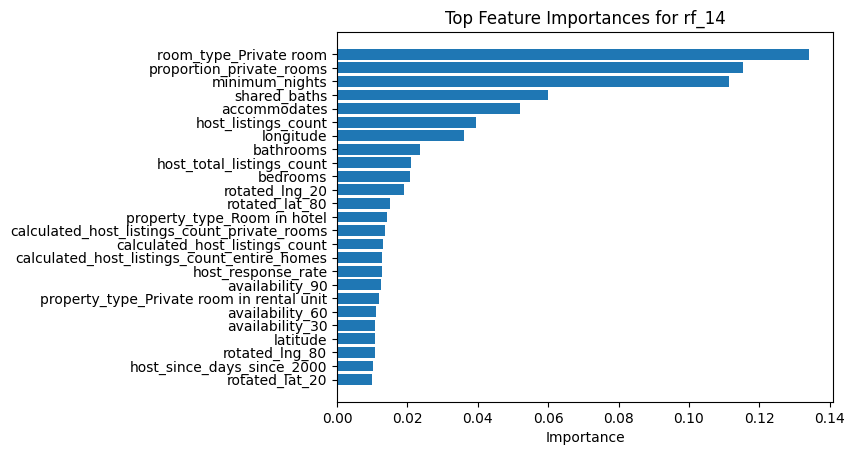

('xgb_stump', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)) RMSE (Unrounded): 0.7962
('xgb_stump', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
         

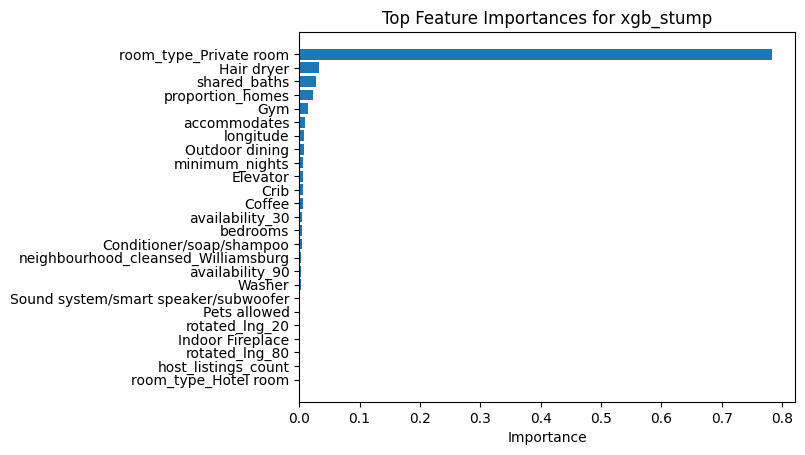

('xgb_depth4', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)) RMSE (Unrounded): 0.7168
('xgb_depth4', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
       

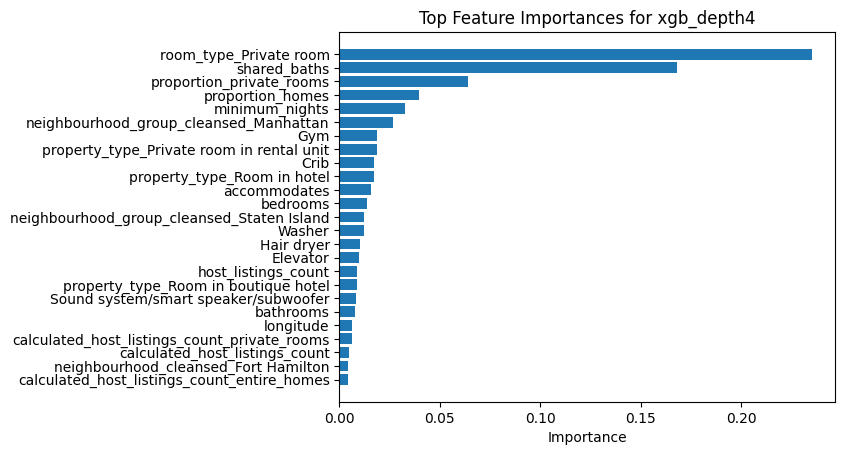

('xgb_depth8', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)) RMSE (Unrounded): 0.7084
('xgb_depth8', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
       

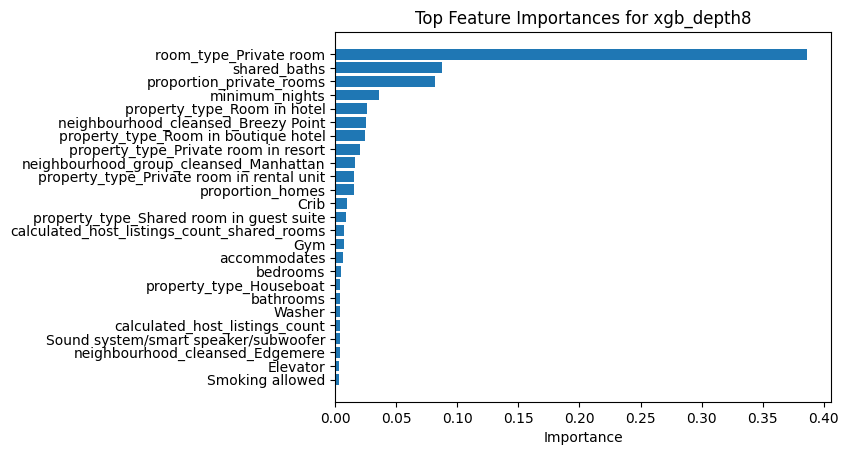

('xgb_depth12', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)) RMSE (Unrounded): 0.7268
('xgb_depth12', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
    

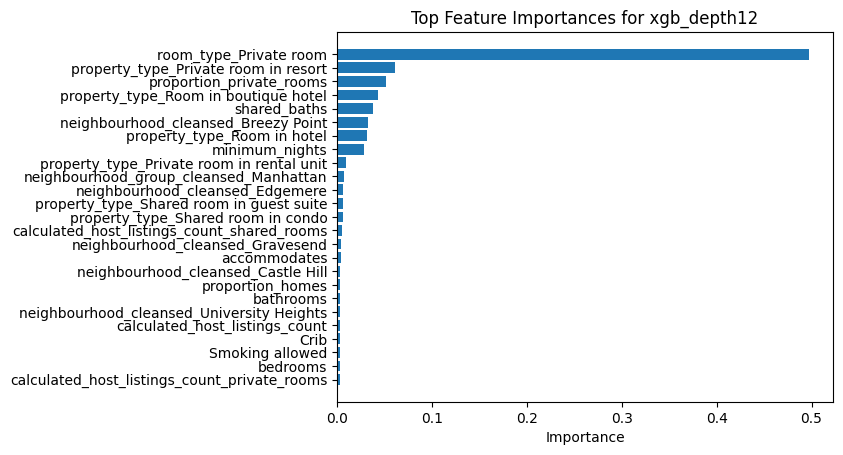

('elastic_1s', Pipeline(steps=[('scaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000,
                            random_state=42))])) RMSE (Unrounded): 0.9537
('elastic_1s', Pipeline(steps=[('scaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000,
                            random_state=42))])) RMSE (rounded): 0.9963
('knn_10_distance', Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=10,
                                     weights='distance'))])) RMSE (Unrounded): 0.9315
('knn_10_distance', Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=10,
                                     weights='distance'))])) RMSE (rounded): 0.9596
Number of remaining models: 7


In [68]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from mord import OrdinalRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#mode = "Sandbox"
mode = "Kaggle"

if mode == "Sandbox":
    #X_layer1, X_layer2, y_layer1, y_layer2 = train_test_split(X_train, y_train, test_size=0.15, random_state=42) # what complements X_train is X_test, which is really just a sandbox test set bc it is split from train
    X_layer1, X_layer2, y_layer1, y_layer2 = train_test_split(X, y, test_size=0.25, random_state=42) # not using a final test set, just rotating folds in layer2 to get best hyperparams
else: 
    X_layer1, X_layer2, y_layer1, y_layer2 = train_test_split(X, y, test_size=0.12, random_state=42) # using all of training data, meaning we have nothing to test on, we are just going to make predictions

how_many_trees = 3200

layer1_models = {
    #"svm_linear": SVR(kernel="linear", C=1.0, epsilon=0.1, cache_size=15000),
    #"svm_rbf": SVR(kernel="rbf", C=1.0, epsilon=0.1, gamma="scale", cache_size=15000),
    #"svm_poly": SVR(kernel="poly", C=1.0, epsilon=0.1, degree=3, gamma="scale", cache_size=15000),
    #"svm_sigmoid": SVR(kernel="sigmoid", C=1.0, epsilon=0.1, gamma="scale", cache_size=15000),
    #"linear_regression": LinearRegression(),
    #"linear_regression_interactions": Pipeline([("scaler", StandardScaler()), ("interactions", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), ("linear_regression", LinearRegression())]),
    #"linear_regression_poly2_interacts": Pipeline([("scaler", StandardScaler()), ("poly", PolynomialFeatures(degree=2, include_bias=False)), ("linear_regression", LinearRegression())]),
    #"linear_regression_poly3_interacts": Pipeline([("scaler", StandardScaler()), ("poly", PolynomialFeatures(degree=3, include_bias=False)), ("linear_regression", LinearRegression())]),
    #"mlp_small": MLPRegressor(hidden_layer_sizes=(32,), max_iter=100000, random_state=42),
    #"mlp_medium": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=100000, random_state=42),
    #"mlp_large": MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=100000, random_state=42),
    #"rf_shallow0": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=6, min_samples_split=2, max_features=0.55, random_state=42, criterion="squared_error"),
    #"rf_shallow1": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=5, min_samples_split=2, max_features=0.8, random_state=42, criterion="squared_error"),
    #"rf_1": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.2, random_state=42, criterion="squared_error"),
    #"rf_2": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.2, random_state=42, criterion="squared_error"),
    #"rf_3": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.2, random_state=42, criterion="squared_error"),
    #"rf_4": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.4, random_state=42, criterion="squared_error"),
    #"rf_5": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.4, random_state=42, criterion="squared_error"),
    #"rf_6": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.4, random_state=42, criterion="squared_error"),
    #"rf_7": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.5, random_state=42, criterion="squared_error"),
    #"rf_8": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.5, random_state=42, criterion="squared_error"),
    #"rf_9": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.5, random_state=42, criterion="squared_error"),
    #"rf_10": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.6, random_state=42, criterion="squared_error"),
    #"rf_11": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.6, random_state=42, criterion="squared_error"),
    #"rf_12": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.6, random_state=42, criterion="squared_error"),
    #"rf_13": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.8, random_state=42, criterion="squared_error"),
    "rf_14": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.8, random_state=42, criterion="squared_error"),
    #"rf_15": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.8, random_state=42, criterion="squared_error"),
    #"rf_16": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.9, random_state=42, criterion="squared_error"),
    #"rf_17": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.9, random_state=42, criterion="squared_error"),
    #"rf_18": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.9, random_state=42, criterion="squared_error"),
    #"rf_19": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.2, random_state=42, criterion="poisson"),
    #"rf_20": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.2, random_state=42, criterion="poisson"),
    #"rf_21": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.2, random_state=42, criterion="poisson"),
    #"rf_22": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.4, random_state=42, criterion="poisson"),
    #"rf_23": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.4, random_state=42, criterion="poisson"),
    #"rf_24": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.4, random_state=42, criterion="poisson"),
    #"rf_25": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.5, random_state=42, criterion="poisson"),
    #"rf_26": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.5, random_state=42, criterion="poisson"),
    #"rf_27": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.5, random_state=42, criterion="poisson"),
    #"rf_28": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.6, random_state=42, criterion="poisson"),
    #"rf_29": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.6, random_state=42, criterion="poisson"),
    #"rf_30": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.6, random_state=42, criterion="poisson"),
    #"rf_31": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.8, random_state=42, criterion="poisson"),
    #"rf_32": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.8, random_state=42, criterion="poisson"),
    #"rf_33": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.8, random_state=42, criterion="poisson"),
    #"rf_34": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.9, random_state=42, criterion="poisson"),
    #"rf_35": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=22, min_samples_split=8, max_features=0.9, random_state=42, criterion="poisson"),
    #"rf_36": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.9, random_state=42, criterion="poisson"),
    #"rf_37": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.2, random_state=42, criterion="absolute_error"),
    #"rf_38": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.2, random_state=42, criterion="absolute_error"),
    #"rf_39": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.2, random_state=42, criterion="absolute_error"),
    #"rf_40": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.4, random_state=42, criterion="absolute_error"),
    #"rf_41": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.4, random_state=42, criterion="absolute_error"),
    #"rf_42": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.4, random_state=42, criterion="absolute_error"),
    #"rf_43": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.5, random_state=42, criterion="absolute_error"),
    #"rf_44": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.5, random_state=42, criterion="absolute_error"),
    #"rf_45": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.5, random_state=42, criterion="absolute_error"),
    #"rf_46": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.6, random_state=42, criterion="absolute_error"),
    #"rf_47": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.6, random_state=42, criterion="absolute_error"),
    #"rf_48": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.6, random_state=42, criterion="absolute_error"),
    #"rf_49": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.8, random_state=42, criterion="absolute_error"),
    #"rf_50": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.8, random_state=42, criterion="absolute_error"),
    #"rf_51": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.8, random_state=42, criterion="absolute_error"),
    #"rf_52": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=2, max_features=0.9, random_state=42, criterion="absolute_error"),
    #"rf_53": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=30, min_samples_split=8, max_features=0.9, random_state=42, criterion="absolute_error"),
    #"rf_54": RandomForestRegressor(n_estimators=how_many_trees, n_jobs=-1, max_depth=8, min_samples_split=8, max_features=0.9, random_state=42, criterion="absolute_error"),
    "xgb_stump": XGBRegressor(max_depth=1, n_estimators=how_many_trees, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    "xgb_depth4": XGBRegressor(max_depth=4, n_estimators=how_many_trees,  learning_rate=0.05, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    "xgb_depth8": XGBRegressor(max_depth=8, n_estimators=how_many_trees,  learning_rate=0.05, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    "xgb_depth12": XGBRegressor(max_depth=12, n_estimators=how_many_trees, learning_rate=0.05, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    #"xgb_depth16": XGBRegressor(max_depth=16, n_estimators=how_many_trees, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    #"xgb_depth24": XGBRegressor(max_depth=24, n_estimators=how_many_trees, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    #"xgb_depth48": XGBRegressor(max_depth=48, n_estimators=how_many_trees, n_jobs=-1, random_state=42, objective='reg:squarederror', verbosity=0),
    #"elastic_1": ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000, random_state=42),
    "elastic_1s": Pipeline([('scaler', StandardScaler()), ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=100000, random_state=42))]),
    #"elastic_2": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=100000, random_state=42),
    #"elastic_3": ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=100000, random_state=42),
    #"elastic_4": ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=100000, random_state=42),
    #"elastic_5": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=100000, random_state=42),
    #"elastic_6": ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100000, random_state=42),
    #"elastic_7": ElasticNet(alpha=1.0, l1_ratio=0.1, max_iter=100000, random_state=42),
    #"elastic_8": ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000, random_state=42),
    #"elastic_9": ElasticNet(alpha=1.0, l1_ratio=0.9, max_iter=100000, random_state=42),
    #"elastic_10": ElasticNet(alpha=10.0, l1_ratio=0.1, max_iter=100000, random_state=42),
    #"elastic_11": ElasticNet(alpha=10.0, l1_ratio=0.5, max_iter=100000, random_state=42),
    #"elastic_12": ElasticNet(alpha=10.0, l1_ratio=0.9, max_iter=100000, random_state=42),
    #"knn_3_uniform": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=3, weights="uniform", metric="euclidean"))]),
    #"knn_5_uniform": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=5, weights="uniform", metric="euclidean"))]),
    #"knn_10_uniform": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=10, weights="uniform", metric="euclidean"))]),
    #"knn_30_uniform": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=30, weights="uniform", metric="euclidean"))]),
    #"knn_3_distance": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=3, weights="distance", metric="manhattan"))]),
    #"knn_5_distance": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=5, weights="distance", metric="manhattan"))]),
    "knn_10_distance": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=10, weights="distance", metric="manhattan"))]),
    #"knn_30_distance": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=30, weights="distance", metric="manhattan"))]),
    #"knn_5_uniform_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=5, weights="uniform", metric="cosine"))]),
    #"knn_10_uniform_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=10, weights="uniform", metric="cosine"))]),
    #"knn_30_uniform_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=30, weights="uniform", metric="cosine"))]),
    #"knn_5_distance_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=5, weights="distance", metric="cosine"))]),
    #"knn_10_distance_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=10, weights="distance", metric="cosine"))]),
    #"knn_30_distance_cosine": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=30, weights="distance", metric="cosine"))])
}

layer1_predictions = {}
for name, model in layer1_models.items():
    #print(name, model)
    model.fit(X_layer1, y_layer1)
    layer1_predictions[name] = model.predict(X_layer2)
    rounded_predictions = np.round(layer1_predictions[name])
    rmse = np.sqrt(mean_squared_error(y_layer2, layer1_predictions[name]))
    print(f"{(name, model)} RMSE (Unrounded): {rmse:.4f}")
    rmse = np.sqrt(mean_squared_error(y_layer2, rounded_predictions))
    print(f"{(name, model)} RMSE (rounded): {rmse:.4f}")

    #if isinstance(model, Pipeline):
    #    model = model.named_steps['elasticnet']

    feature_importances = None
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        feature_importances = np.abs(model.coef_)
    
    if feature_importances is not None:
        sorted_idx = np.argsort(feature_importances)[-25:]
        top_features = X_layer1.columns[sorted_idx] if hasattr(X_layer1, "columns") else sorted_idx
        top_importances = feature_importances[sorted_idx]
        
        plt.barh(range(len(top_features)), top_importances, align='center')
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel("Importance")
        plt.title(f"Top Feature Importances for {name}")
        plt.show()

#X_layer2_stacked = np.column_stack(list(layer1_predictions.values()))

# Compare pairwise predictions and remove redundant models
from itertools import combinations
redundant_models = set()
models = list(layer1_predictions.keys())
for model1, model2 in combinations(models, 2):
    predictions1 = layer1_predictions[model1]
    predictions2 = layer1_predictions[model2]
    
    relative_diff = np.abs(predictions1 - predictions2) / np.ptp(y_layer2)
    avg_relative_diff = np.mean(relative_diff)
    
    # If predictions differ by less than 1%, mark one of the models as redundant
    if avg_relative_diff < 0.03:
        print(f"Models {model1} and {model2} are redundant (avg diff: {avg_relative_diff:.6f}). Removing {model2}.")
        redundant_models.add(model2)

# Remove redundant models
for redundant_model in redundant_models:
    del layer1_predictions[redundant_model]
    del layer1_models[redundant_model]

# Stack predictions from non-redundant models
X_layer2_stacked = np.column_stack(list(layer1_predictions.values()))
print(f"Number of remaining models: {len(layer1_predictions)}")

In [69]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

expected_features = X.columns

# Add missing columns (columns from training not represented here, which is just one-hot encoded stuff) with 0 values
for feature in expected_features:
    if feature not in real_test.columns:
        real_test[feature] = 0

# Remove extra columns not in the training set
real_test = real_test[expected_features]

layer1_test_predictions = {}
for name, model in layer1_models.items():
    if mode == "Sandbox":
        layer1_test_predictions[name] = model.predict(X_test) # for Sandbox predictions
    else:
        layer1_test_predictions[name] = model.predict(real_test) # for Kaggle predictions

def rounded_rmse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    return mean_squared_error(y_true, y_pred_rounded)**0.5

rounded_rmse_scorer = make_scorer(rounded_rmse, greater_is_better=False)


# all layer 1 model predictions, to be synthesized
if mode == "Kaggle":
    X_test_stacked = np.column_stack(list(layer1_test_predictions.values()))

    print("Metamodel")

    num_rounded = round(len(layer1_models) * 0.5)
    print(f"Recommended Depth for metamodel: {num_rounded}")
    #layer2_modelrf = RandomForestRegressor(n_estimators=5500, max_depth=10, min_samples_split=9, max_features=0.464, random_state=42, criterion="squared_error")
    #layer2_modelrf = RandomForestClassifier(n_estimators=800, max_depth=14, min_samples_split=2, max_features=0.8, random_state=42)
    layer2_modelrf = LinearRegression() # fit_intercept=False is an option

    layer2_modelrf.fit(X_layer2_stacked, y_layer2)
    y_pred_before_rounding = layer2_modelrf.predict(X_test_stacked)

    if isinstance(layer2_modelrf, (RandomForestRegressor, LinearRegression)):
        y_pred = np.round(y_pred_before_rounding).astype(int)
        y_pred[y_pred < 0] = 0
        y_pred[y_pred > 5] = 5
    else:
        y_pred = y_pred_before_rounding

    y_pred = pd.Series(y_pred, name='y_pred')
    result = pd.concat([id, y_pred], axis=1)
    result.to_csv('final.csv', index=False)
    print("SAVED")

    if not isinstance(layer2_modelrf, LinearRegression):
        feature_importances = layer2_modelrf.feature_importances_
        feature_names = list(layer1_models.keys())
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, feature_importances, align='center')
        plt.xlabel("Layer 1 Model Importance")
        plt.title("Layer 1 Model Importances for Layer 2")
        plt.tight_layout()
        plt.show()
    else:
        feature_names = list(layer1_models.keys())
        coefficients = layer2_modelrf.coef_ 
        intercept = layer2_modelrf.intercept_
        equation = " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(coefficients, feature_names)])
        equation = f"y = {intercept:.4f} + {equation}"

        print("Equation of the model:")
        print(equation)

else: 
    X_test_stacked = np.column_stack(list(layer1_test_predictions.values()))

    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        max_features = trial.suggest_float('max_features', 0.1, 1.0)

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            criterion="squared_error"
        )
        #model = LinearRegression()
        #model = LogisticRegression(
        #    solver='lbfgs', 
        #    max_iter=500000,
        #    random_state=42
        #)
        #model = XGBRegressor(
        #    n_estimators=n_estimators,
        #    max_depth=max_depth,
        #    random_state=42
        #)
        #model = DecisionTreeRegressor(
        #    max_depth=max_depth,
        #    min_samples_split=min_samples_split,
        #    random_state=42
        #)

        #neg_mse = cross_val_score(
        #    model, X_layer2_stacked, y_layer2, scoring='neg_mean_squared_error', cv=5
        #)
        #return -1 * np.mean(neg_mse)
        neg_rounded_rmse = cross_val_score(
        model, X_layer2_stacked, y_layer2, scoring=rounded_rmse_scorer, cv=5
        )
        return -1 * np.mean(neg_rounded_rmse)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    print(f"Best parameters: {best_params}")



Metamodel
Recommended Depth for metamodel: 4
SAVED
Equation of the model:
y = -0.0447 + 0.1609*rf_14 + 0.1229*xgb_stump + 0.3108*xgb_depth4 + 0.2982*xgb_depth8 + 0.1521*xgb_depth12 + -0.0509*elastic_1s + 0.0352*knn_10_distance
